In [ ]:
!pip install tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

Let's start by using the network in order to integrate the differential equations deriving from separation of the radial and angular motion. Later we will pass to use it as an HNN, i.e passing the Hamilton's equations (it does not require that the geometry is seperable).

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_6 (Dense)             (None, 50)                100       
                                                                 
 tf_op_layer_Sin_4 (TensorF  multiple                  0         
 lowOpLayer)                                                     
                                                                 
 dense_7 (Dense)             (None, 50)                2550      
                                                                 
 tf_op_layer_Sin_5 (TensorF  multiple                  0         
 lowOpLayer)                                                     
                                                                 
 dense_8 (Dense)             (None, 2)                 102 

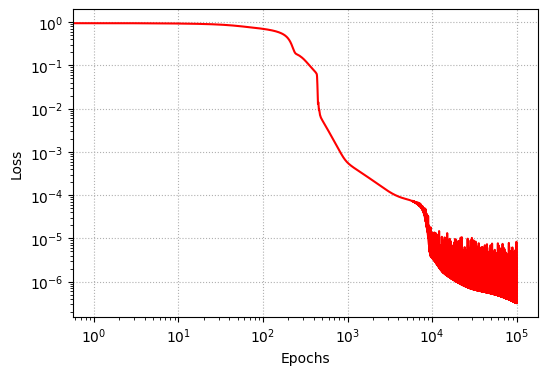

In [ ]:
#TRAINING

import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


import time
import numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import solve_ivp
from tensorflow import keras, Variable
from tensorflow.keras.optimizers import SGD, RMSprop, Nadam, Adagrad
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU, Concatenate
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import Conv1D, Conv2D,  UpSampling2D, Conv1DTranspose, MaxPool1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.python.framework.ops import disable_eager_execution
import sys
disable_eager_execution()

def info(obj,name):
  print(name,' shape: ',np.shape(obj),' type: ',type(obj), '\n')

np.random.seed(1)
keras.utils.set_random_seed(812)       #c'è differenza tra questi due comandi? La prima funzione fissa il seme della generazione dei numeri pseudocasuali su numpy,
                                       #il secondo serve per inizializzare in modo randomico i parametri della rete. Fissando il seme si fa in modo che ogni volta che
                                       #si ripete il codice i parametri iniziali della rete siano gli stessi

def scheduler(epoch, lr):              #si noti che in ingresso alla funzione si ha lr perchè questa funzione viene chiamata durante il training della rete dove viene usato lr:
                                       #per le prime 5000 epoche è uguale a lri, ma dopo di esse viene fatto diminuire con la legge riportata nell'else
  if epoch <= 5000:
    lr = lri
  else:
    lr = lr/(1+0.00001*epoch)
  return lr

#### Geodesic Parameters
L  = 1
af = 0.1
b  = 1.89

#### Integration Parameters
rho_0   = 10
phi_0   = np.arcsin(b/rho_0)
t_start = 0
t_final = 40
npoints = 200
t_eval  = np.linspace(t_start,t_final,npoints)

if b==1.9:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt(0.000000000000000000000000000000000001+tf.math.abs((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2)))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
else:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def ang(rho):
  return (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def f(t):
  return 1 - tf.math.exp(-t)

def df(t):
  return tf.math.exp(-t)

def custom_activation(x):
  return tf.math.sin(x)



def custom_loss(t,N):

  def loss(y_true, y_pred):         #questo è un trucco per far fare alla rete ciò che ci serve: lei legge, come argomento della funzione loss, y_true e y_pred, quando a noi
                                    #interessa che la loss dipenda da N e t. Allora, facciamo restituire dalla funzione custom_loss la funzione loss, che è quella che la rete
                                    #"riconosce", ma visto che in ingresso a custum_loss ci sono N e t, questi entrano nella loss calcolata e minimizzata poi (durante il training)
                                    #dalla rete, ottenendo il nostro obiettivo
    ft  = f(t)
    dft = df(t)

    with tf.GradientTape() as tape:
      tape.watch(t)
      predictions = model(t,training=False)                   #è equivalente a model.predict? No, prima va allenata e dopo predice con model.predict
    gradients     = tape.batch_jacobian(predictions,t)        #vorrei capire meglio. La spiegazione è che sembra che con tape.gradient si calcolino le derivate dell'output
                                                              #rispetto a t e poi vengano sommate tutte le derivate, invece con batch_jacobian le derivate non vengano
                                                              #sommate ed è ciò che vogliamo
    gradients     = tf.reshape(gradients, (-1,2))

    rho             = rho_0+ft[:,0]*N[:,0]
    phi             = phi_0+ft[:,0]*N[:,1]

    rho_dot          = ft[:,0]*gradients[:,0] + dft[:,0]*N[:,0]
    phi_dot          = ft[:,0]*gradients[:,1] + dft[:,0]*N[:,1]

    eq1sep           = tf.square(rho_dot - rad(rho))
    eq2sep           = tf.square(phi_dot - ang(rho))
    total_loss_sep    = eq1sep  +  eq2sep

    return tf.reduce_mean(total_loss_sep)                #qui viene restituita come loss la media dei valori assunti da essa ai diversi tempi (quindi questo è il valore della loss
                                                     #alla data epoca)

  return loss     #questa loss è la funzione di sopra, quella riconosciuta dalla rete

# initial condition
z0  = np.array([rho_0,phi_0])

arc     = 'arc1'
lri     = 4e-4
X_train = t_eval # np.array([ [0], [0.5] ])
Y_train = np.zeros(len(X_train))

initializer  = 'random_normal'                    #l'inizializzatore serve a generare casualmente i parametri della rete e qui viene fatto con una distribuzione normale
opt          =  Adam(learning_rate=lri)

csv_logger   = CSVLogger(f'loss.dat', append=False, separator=' ')   #Questa callback serve a scrivere su un file il valore della loss a ogni epoca volta per volta
my_callbacks = [csv_logger]

if arc == 'arc1':                                 #ricordo che qui viene impostata l'architettura della rete
  input_layer = Input(shape=(1))
  branch = Dense(50, kernel_initializer=initializer)(input_layer)
  branch = custom_activation(branch)
  branch = Dense(50, kernel_initializer=initializer)(branch)
  branch = custom_activation(branch)
  output_layer = Dense(2, kernel_initializer=initializer)(branch)



model  = Model( inputs = input_layer , outputs = output_layer)    #qui invece viene impostato il modello
model.compile( loss=custom_loss(input_layer,output_layer), optimizer = opt )   #e qui viene compilato

model.summary()
# param = model.count_params()

EPOCHS  = 100000

start_time = time.time()
print(f'Training with {EPOCHS} epochs ...')
history = model.fit( x = X_train, y = None, epochs=EPOCHS, verbose = 0,batch_size = len(X_train), callbacks = [my_callbacks]) #qui invece viene fatto il training, ossia la minimizzazione della loss alle
                                                                                                                              #varie epoche. Avremmo potuto mettere y=Y_train, essendo comunque tutti 0.

print(f'Elapsed time = {time.time()-start_time} sec = {(time.time()-start_time)/60} min')

# Plot Loss Function
loss_1 = history.history['loss']     #grazie alla callback csv_logger, potremmo vedere come va la loss alle varie epoche senza aspettare tutto il training, cosa invece necessaria
                                     #con history.history
plt.figure(figsize=(6,4))
plt.plot(loss_1,color='red')
plt.yscale('log')
plt.xscale('log')
plt.grid(0.5,ls='dotted')
plt.xlabel('Epochs')
plt.ylabel('Loss')


# Prediction
prediction = model.predict(X_train)
solution = []
for n in range(len(prediction)):
  z = z0 + (1-np.exp(-X_train[n]))* prediction[n]
  solution.append(z)
prediction = np.transpose(solution)
rho_nn = prediction[0]
phi_nn = prediction[1]
x_nn = rho_nn*np.cos(phi_nn)
y_nn = rho_nn*np.sin(phi_nn)


In [ ]:
# Numerical Integration via solve_ivp using Runge-Kutta method of order 5(4)
def system(t,y):
  rho, phi = y
  drho_dt = -(rho**2 + af**2)*np.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  dphi_dt = (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  return [drho_dt, dphi_dt]

num_sol = solve_ivp(system, t_span=(t_eval[0],t_eval[-1]), y0=[rho_0,phi_0], t_eval = t_eval)
rho_num = num_sol.y[0]
phi_num = num_sol.y[1]
x_num = rho_num*np.cos(phi_num)
y_num = rho_num*np.sin(phi_num)

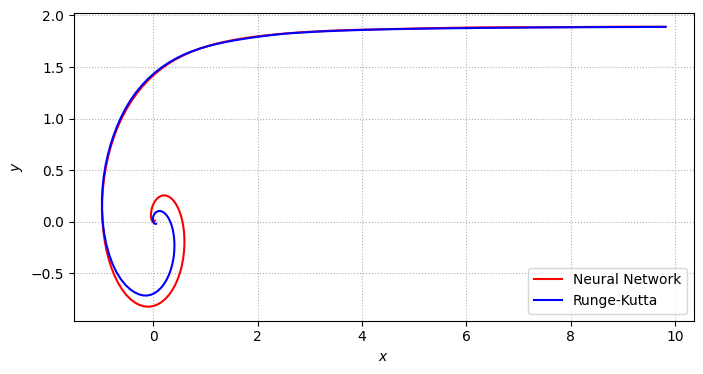

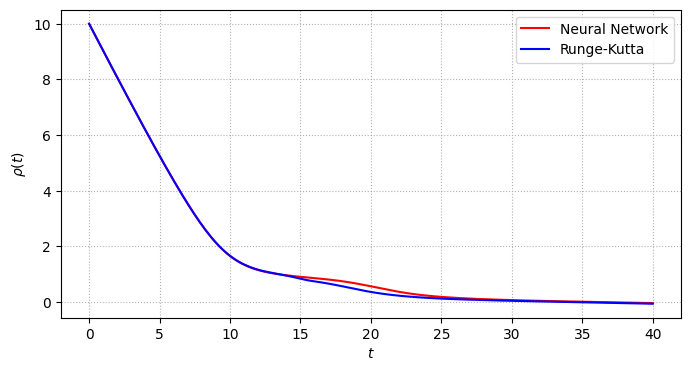

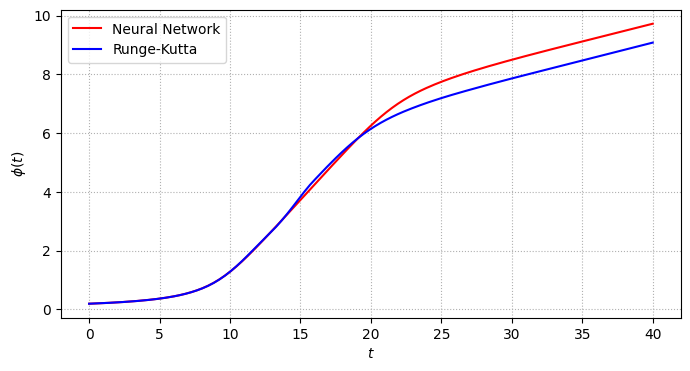

In [ ]:
# Let's plot and compare the results

plt.figure(figsize=(8,4))
plt.plot(x_nn,y_nn, ls='-', color='red', label='Neural Network')
plt.plot(x_num,y_num, ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(X_train,rho_nn, ls='-', color='red', label='Neural Network')
plt.plot(X_train,rho_num,ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel(r'$\rho(t)$')
plt.show()


plt.figure(figsize=(8,4))
plt.plot(X_train,phi_nn, ls = '-', color = 'red', label='Neural Network')
plt.plot(X_train,phi_num, ls = '-', color = 'blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$\phi(t)$')
plt.show()

It seems that when the learning rate is 4*10^{-4}, the agreement is better, even if the loss function at the end of the training is more oscillating.

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_12 (Dense)            (None, 50)                100       
                                                                 
 tf_op_layer_Sin_8 (TensorF  multiple                  0         
 lowOpLayer)                                                     
                                                                 
 dense_13 (Dense)            (None, 50)                2550      
                                                                 
 tf_op_layer_Sin_9 (TensorF  multiple                  0         
 lowOpLayer)                                                     
                                                                 
 dense_14 (Dense)            (None, 2)                 102 

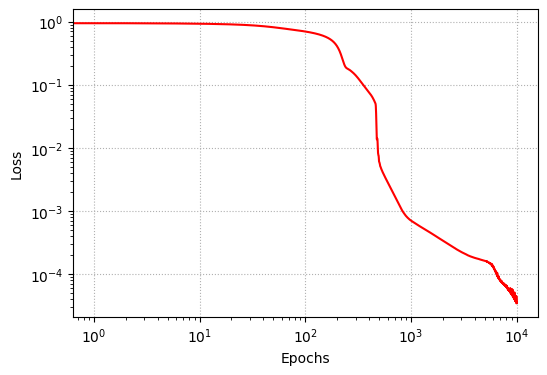

In [ ]:
#TRAINING

import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


import time
import numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import solve_ivp
from tensorflow import keras, Variable
from tensorflow.keras.optimizers import SGD, RMSprop, Nadam, Adagrad
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU, Concatenate
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import Conv1D, Conv2D,  UpSampling2D, Conv1DTranspose, MaxPool1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.python.framework.ops import disable_eager_execution
import sys
disable_eager_execution()

def info(obj,name):
  print(name,' shape: ',np.shape(obj),' type: ',type(obj), '\n')

np.random.seed(1)
keras.utils.set_random_seed(812)       #c'è differenza tra questi due comandi? La prima funzione fissa il seme della generazione dei numeri pseudocasuali su numpy,
                                       #il secondo serve per inizializzare in modo randomico i parametri della rete. Fissando il seme si fa in modo che ogni volta che
                                       #si ripete il codice i parametri iniziali della rete siano gli stessi

def scheduler(epoch, lr):              #si noti che in ingresso alla funzione si ha lr perchè questa funzione viene chiamata durante il training della rete dove viene usato lr:
                                       #per le prime 5000 epoche è uguale a lri, ma dopo di esse viene fatto diminuire con la legge riportata nell'else
  if epoch <= 5000:
    lr = lri
  else:
    lr = lr/(1+0.00001*epoch)
  return lr

#### Geodesic Parameters
L  = 1
af = 0.1
b  = 1.9

#### Integration Parameters
rho_0   = 10
phi_0   = np.arcsin(b/rho_0)
t_start = 0
t_final = 40
npoints = 200
t_eval  = np.linspace(t_start,t_final,npoints)

if b==1.9:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt(0.000000000000000000000000000000000001+tf.math.abs((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2)))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
else:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def ang(rho):
  return (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def f(t):
  return 1 - tf.math.exp(-t)

def df(t):
  return tf.math.exp(-t)

def custom_activation(x):
  return tf.math.sin(x)



def custom_loss(t,N):

  def loss(y_true, y_pred):         #questo è un trucco per far fare alla rete ciò che ci serve: lei legge, come argomento della funzione loss, y_true e y_pred, quando a noi
                                    #interessa che la loss dipenda da N e t. Allora, facciamo restituire dalla funzione custom_loss la funzione loss, che è quella che la rete
                                    #"riconosce", ma visto che in ingresso a custum_loss ci sono N e t, questi entrano nella loss calcolata e minimizzata poi (durante il training)
                                    #dalla rete, ottenendo il nostro obiettivo
    ft  = f(t)
    dft = df(t)

    with tf.GradientTape() as tape:
      tape.watch(t)
      predictions = model(t,training=False)                   #è equivalente a model.predict? No, prima va allenata e dopo predice con model.predict
    gradients     = tape.batch_jacobian(predictions,t)        #vorrei capire meglio. La spiegazione è che sembra che con tape.gradient si calcolino le derivate dell'output
                                                              #rispetto a t e poi vengano sommate tutte le derivate, invece con batch_jacobian le derivate non vengano
                                                              #sommate ed è ciò che vogliamo
    gradients     = tf.reshape(gradients, (-1,2))

    rho             = rho_0+ft[:,0]*N[:,0]
    phi             = phi_0+ft[:,0]*N[:,1]

    rho_dot          = ft[:,0]*gradients[:,0] + dft[:,0]*N[:,0]
    phi_dot          = ft[:,0]*gradients[:,1] + dft[:,0]*N[:,1]

    eq1sep           = tf.square(rho_dot - rad(rho))
    eq2sep           = tf.square(phi_dot - ang(rho))
    total_loss_sep    = eq1sep  +  eq2sep

    return tf.reduce_mean(total_loss_sep)                #qui viene restituita come loss la media dei valori assunti da essa ai diversi tempi (quindi questo è il valore della loss
                                                     #alla data epoca)

  return loss     #questa loss è la funzione di sopra, quella riconosciuta dalla rete

# initial condition
z0  = np.array([rho_0,phi_0])

arc     = 'arc1'
lri     = 4e-4
X_train = t_eval # np.array([ [0], [0.5] ])
Y_train = np.zeros(len(X_train))

initializer  = 'random_normal'                    #l'inizializzatore serve a generare casualmente i parametri della rete e qui viene fatto con una distribuzione normale
opt          =  Adam(learning_rate=lri)

csv_logger   = CSVLogger(f'loss.dat', append=False, separator=' ')   #Questa callback serve a scrivere su un file il valore della loss a ogni epoca volta per volta
my_callbacks = [csv_logger]

if arc == 'arc1':                                 #ricordo che qui viene impostata l'architettura della rete
  input_layer = Input(shape=(1))
  branch = Dense(50, kernel_initializer=initializer)(input_layer)
  branch = custom_activation(branch)
  branch = Dense(50, kernel_initializer=initializer)(branch)
  branch = custom_activation(branch)
  output_layer = Dense(2, kernel_initializer=initializer)(branch)



model  = Model( inputs = input_layer , outputs = output_layer)    #qui invece viene impostato il modello
model.compile( loss=custom_loss(input_layer,output_layer), optimizer = opt )   #e qui viene compilato

model.summary()
# param = model.count_params()

EPOCHS  = 10000

start_time = time.time()
print(f'Training with {EPOCHS} epochs ...')
history = model.fit( x = X_train, y = None, epochs=EPOCHS, verbose = 0,batch_size = len(X_train), callbacks = [my_callbacks]) #qui invece viene fatto il training, ossia la minimizzazione della loss alle
                                                                                                                              #varie epoche. Avremmo potuto mettere y=Y_train, essendo comunque tutti 0.

print(f'Elapsed time = {time.time()-start_time} sec = {(time.time()-start_time)/60} min')

# Plot Loss Function
loss_1 = history.history['loss']     #grazie alla callback csv_logger, potremmo vedere come va la loss alle varie epoche senza aspettare tutto il training, cosa invece necessaria
                                     #con history.history
plt.figure(figsize=(6,4))
plt.plot(loss_1,color='red')
plt.yscale('log')
plt.xscale('log')
plt.grid(0.5,ls='dotted')
plt.xlabel('Epochs')
plt.ylabel('Loss')


# Prediction
prediction = model.predict(X_train)
solution = []
for n in range(len(prediction)):
  z = z0 + (1-np.exp(-X_train[n]))* prediction[n]
  solution.append(z)
prediction = np.transpose(solution)
rho_nn = prediction[0]
phi_nn = prediction[1]
x_nn = rho_nn*np.cos(phi_nn)
y_nn = rho_nn*np.sin(phi_nn)


In [ ]:
# Numerical Integration via solve_ivp using Runge-Kutta method of order 5(4)
def system(t,y):
  rho, phi = y
  drho_dt = -(rho**2 + af**2)*np.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  dphi_dt = (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  return [drho_dt, dphi_dt]

num_sol = solve_ivp(system, t_span=(t_eval[0],t_eval[-1]), y0=[rho_0,phi_0], t_eval = t_eval)
rho_num = num_sol.y[0]
phi_num = num_sol.y[1]
x_num = rho_num*np.cos(phi_num)
y_num = rho_num*np.sin(phi_num)

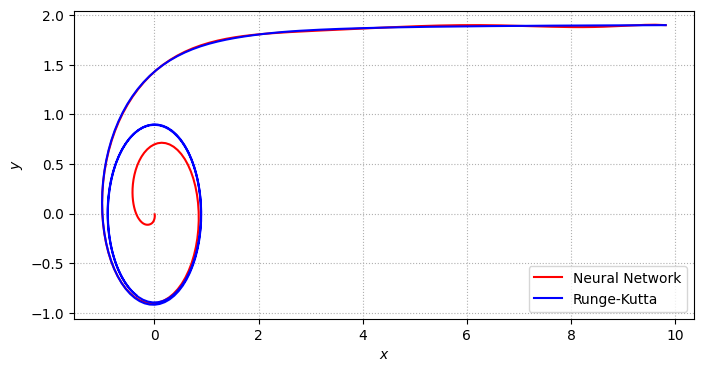

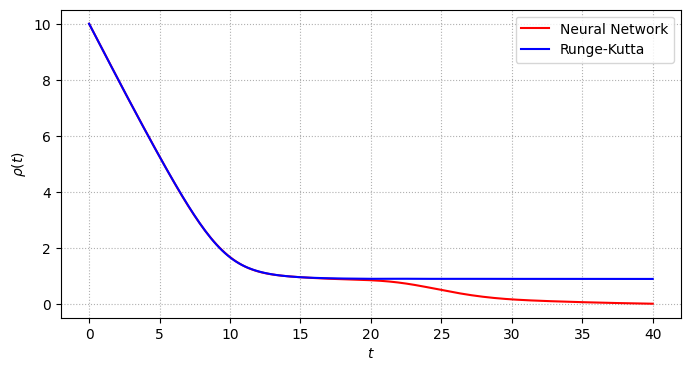

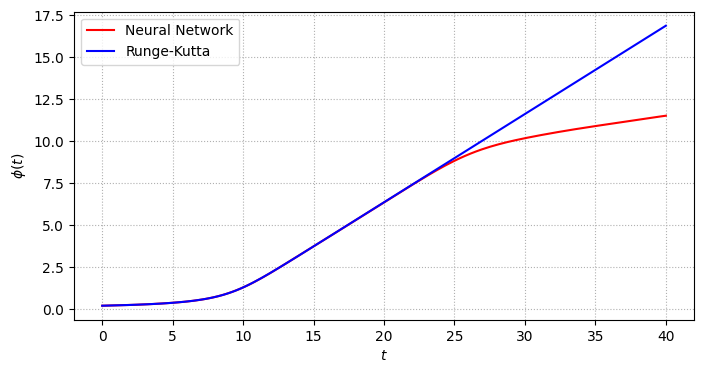

In [ ]:
# Let's plot and compare the results

plt.figure(figsize=(8,4))
plt.plot(x_nn,y_nn, ls='-', color='red', label='Neural Network')
plt.plot(x_num,y_num, ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(X_train,rho_nn, ls='-', color='red', label='Neural Network')
plt.plot(X_train,rho_num,ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel(r'$\rho(t)$')
plt.show()


plt.figure(figsize=(8,4))
plt.plot(X_train,phi_nn, ls = '-', color = 'red', label='Neural Network')
plt.plot(X_train,phi_num, ls = '-', color = 'blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$\phi(t)$')
plt.show()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_18 (Dense)            (None, 50)                100       
                                                                 
 tf_op_layer_Sin_12 (Tensor  multiple                  0         
 FlowOpLayer)                                                    
                                                                 
 dense_19 (Dense)            (None, 50)                2550      
                                                                 
 tf_op_layer_Sin_13 (Tensor  multiple                  0         
 FlowOpLayer)                                                    
                                                                 
 dense_20 (Dense)            (None, 1)                 51  

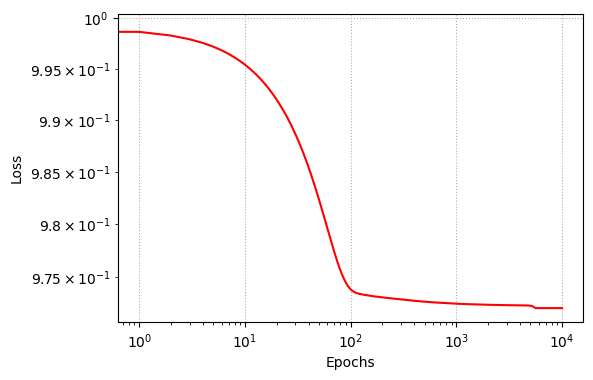

In [ ]:
#TRAINING

import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


import time
import numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import solve_ivp
from tensorflow import keras, Variable
from tensorflow.keras.optimizers import SGD, RMSprop, Nadam, Adagrad
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU, Concatenate
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import Conv1D, Conv2D,  UpSampling2D, Conv1DTranspose, MaxPool1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.python.framework.ops import disable_eager_execution
import sys
disable_eager_execution()

def info(obj,name):
  print(name,' shape: ',np.shape(obj),' type: ',type(obj), '\n')

np.random.seed(1)
keras.utils.set_random_seed(812)       #c'è differenza tra questi due comandi? La prima funzione fissa il seme della generazione dei numeri pseudocasuali su numpy,
                                       #il secondo serve per inizializzare in modo randomico i parametri della rete. Fissando il seme si fa in modo che ogni volta che
                                       #si ripete il codice i parametri iniziali della rete siano gli stessi

def scheduler(epoch, lr):              #si noti che in ingresso alla funzione si ha lr perchè questa funzione viene chiamata durante il training della rete dove viene usato lr:
                                       #per le prime 5000 epoche è uguale a lri, ma dopo di esse viene fatto diminuire con la legge riportata nell'else
  if epoch <= 5000:
    lr = lri
  else:
    lr = lr/(1+0.00001*epoch)
  return lr

#### Geodesic Parameters
L  = 1
af = 0.1
b  = 0

#### Integration Parameters
rho_start = 10
rho_final = 0
phi_0   = np.arcsin(b/rho_start)
npoints = 200
rho_eval  = np.linspace(rho_start,rho_final,npoints)

#if b==1.9:
#  def rad(rho):
#   return -(rho**2 + af**2)*tf.math.sqrt(0.000000000000000000000000000000000001+tf.math.abs((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2)))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
#else:
#  def rad(rho):
#    return -(rho**2 + af**2)*tf.math.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

#def ang(rho):
#  return (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)


def diff_eq(rho):
    return -(af * L**2 + b * rho**2)/((af**2 + rho**2)*(tf.math.sqrt(rho**2 * (af**2 - b**2 + 2 * L**2) + 2 * af * L**2 * (af - b) + L**4 + rho**4)))

def f(rho):
  return 1 - tf.math.exp(-rho)

def df(rho):
  return tf.math.exp(-rho)

def custom_activation(x):
  return tf.math.sin(x)



def custom_loss(rho,N):

  def loss(y_true, y_pred):         #questo è un trucco per far fare alla rete ciò che ci serve: lei legge, come argomento della funzione loss, y_true e y_pred, quando a noi
                                    #interessa che la loss dipenda da N e t. Allora, facciamo restituire dalla funzione custom_loss la funzione loss, che è quella che la rete
                                    #"riconosce", ma visto che in ingresso a custum_loss ci sono N e t, questi entrano nella loss calcolata e minimizzata poi (durante il training)
                                    #dalla rete, ottenendo il nostro obiettivo
    frho  = f(rho)
    dfrho = df(rho)

    with tf.GradientTape() as tape:
      tape.watch(rho)
      predictions = model(rho,training=False)                   #è equivalente a model.predict? No, prima va allenata e dopo predice con model.predict
    gradients     = tape.batch_jacobian(predictions,rho)        #vorrei capire meglio. La spiegazione è che sembra che con tape.gradient si calcolino le derivate dell'output
                                                              #rispetto a t e poi vengano sommate tutte le derivate, invece con batch_jacobian le derivate non vengano
                                                              #sommate ed è ciò che vogliamo
    gradients     = tf.reshape(gradients, (-1,1))

    phi             = phi_0+frho[:,0]*N[:,0]

    phi_dot          = frho[:,0]*gradients[:,0] + dfrho[:,0]*N[:,0]

    eq1new           = tf.square(phi_dot - diff_eq(rho))
    total_loss_new    = eq1new

    return tf.reduce_mean(total_loss_new)                #qui viene restituita come loss la media dei valori assunti da essa ai diversi tempi (quindi questo è il valore della loss
                                                     #alla data epoca)

  return loss     #questa loss è la funzione di sopra, quella riconosciuta dalla rete

# initial condition
z0  = np.array([phi_0])

arc     = 'arc1'
lri     = 2e-4
X_train = rho_eval # np.array([ [0], [0.5] ])
Y_train = np.zeros(len(X_train))

initializer  = 'random_normal'                    #l'inizializzatore serve a generare casualmente i parametri della rete e qui viene fatto con una distribuzione normale
opt          =  Adam(learning_rate=lri)

csv_logger   = CSVLogger(f'loss.dat', append=False, separator=' ')   #Questa callback serve a scrivere su un file il valore della loss a ogni epoca volta per volta
my_callbacks = [csv_logger]

if arc == 'arc1':                                 #ricordo che qui viene impostata l'architettura della rete
  input_layer = Input(shape=(1))
  branch = Dense(50, kernel_initializer=initializer)(input_layer)
  branch = custom_activation(branch)
  branch = Dense(50, kernel_initializer=initializer)(branch)
  branch = custom_activation(branch)
  output_layer = Dense(1, kernel_initializer=initializer)(branch)



model  = Model( inputs = input_layer , outputs = output_layer)    #qui invece viene impostato il modello
model.compile( loss=custom_loss(input_layer,output_layer), optimizer = opt )   #e qui viene compilato

model.summary()
# param = model.count_params()

EPOCHS  = 10000

start_time = time.time()
print(f'Training with {EPOCHS} epochs ...')
history = model.fit( x = X_train, y = None, epochs=EPOCHS, verbose = 0,batch_size = len(X_train), callbacks = [my_callbacks]) #qui invece viene fatto il training, ossia la minimizzazione della loss alle
                                                                                                                              #varie epoche. Avremmo potuto mettere y=Y_train, essendo comunque tutti 0.

print(f'Elapsed time = {time.time()-start_time} sec = {(time.time()-start_time)/60} min')

# Plot Loss Function
loss_1 = history.history['loss']     #grazie alla callback csv_logger, potremmo vedere come va la loss alle varie epoche senza aspettare tutto il training, cosa invece necessaria
                                     #con history.history
plt.figure(figsize=(6,4))
plt.plot(loss_1,color='red')
plt.yscale('log')
plt.xscale('log')
plt.grid(0.5,ls='dotted')
plt.xlabel('Epochs')
plt.ylabel('Loss')


# Prediction
prediction = model.predict(X_train)
solution = []
for n in range(len(prediction)):
  z = z0 + (1-np.exp(-X_train[n]))* prediction[n]
  solution.append(z)
prediction = np.transpose(solution)
phi_nn = prediction[0]
x_nn = rho_eval*np.cos(phi_nn)
y_nn = rho_eval*np.sin(phi_nn)


In [ ]:
# Numerical Integration via solve_ivp using Runge-Kutta method of order 5(4)
def system(rho,y):
  phi = y
  dphi_drho =  -(af * L**2 + b * rho**2)/((af**2 + rho**2)*(np.sqrt(rho**2 * (af**2 - b**2 + 2 * L**2) + 2 * af * L**2 * (af - b) + L**4 + rho**4)))
  return dphi_drho

num_sol = solve_ivp(system, t_span=(rho_eval[0],rho_eval[-1]), y0=[rho_start], t_eval = rho_eval)
phi_num = num_sol.y[0]
x_num = rho_eval*np.cos(phi_num)
y_num = rho_eval*np.sin(phi_num)

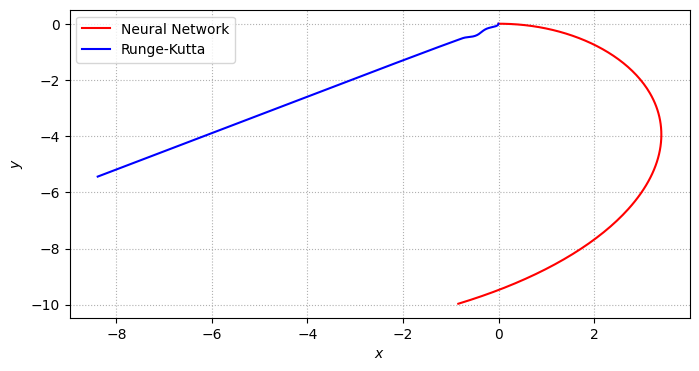

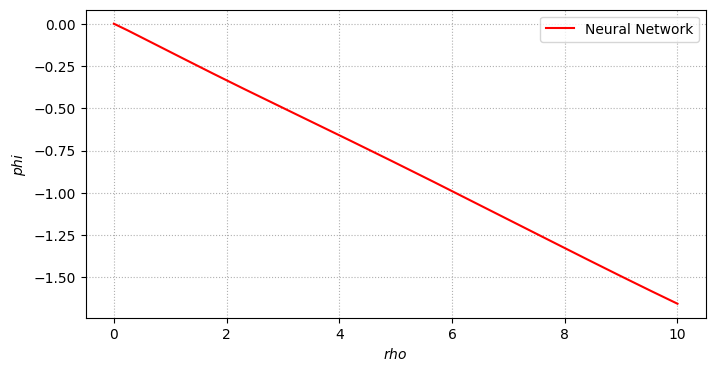

In [ ]:
# Let's plot and compare the results

plt.figure(figsize=(8,4))
plt.plot(x_nn,y_nn, ls='-', color='red', label='Neural Network')
plt.plot(x_num,y_num, ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(rho_eval, phi_nn, ls='-', color='red', label='Neural Network')
#plt.plot(rho_eval, phi_num, ls='-', color='blue', label='RK')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$rho$')
plt.ylabel('$phi$')
plt.show()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_15 (Dense)            (None, 100)               200       
                                                                 
 tf_op_layer_Sin_10 (Tensor  multiple                  0         
 FlowOpLayer)                                                    
                                                                 
 dense_16 (Dense)            (None, 100)               10100     
                                                                 
 tf_op_layer_Sin_11 (Tensor  multiple                  0         
 FlowOpLayer)                                                    
                                                                 
 dense_17 (Dense)            (None, 2)                 202 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


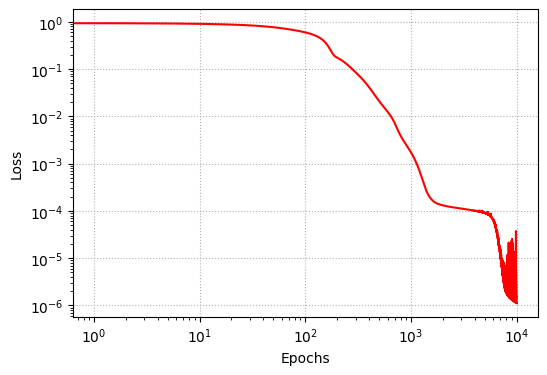

In [ ]:
#TRAINING

import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


import time
import numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import solve_ivp
from tensorflow import keras, Variable
from tensorflow.keras.optimizers import SGD, RMSprop, Nadam, Adagrad
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU, Concatenate
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import Conv1D, Conv2D,  UpSampling2D, Conv1DTranspose, MaxPool1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.python.framework.ops import disable_eager_execution
import sys
disable_eager_execution()

def info(obj,name):
  print(name,' shape: ',np.shape(obj),' type: ',type(obj), '\n')

np.random.seed(1)
keras.utils.set_random_seed(812)       #c'è differenza tra questi due comandi? La prima funzione fissa il seme della generazione dei numeri pseudocasuali su numpy,
                                       #il secondo serve per inizializzare in modo randomico i parametri della rete. Fissando il seme si fa in modo che ogni volta che
                                       #si ripete il codice i parametri iniziali della rete siano gli stessi

def scheduler(epoch, lr):              #si noti che in ingresso alla funzione si ha lr perchè questa funzione viene chiamata durante il training della rete dove viene usato lr:
                                       #per le prime 5000 epoche è uguale a lri, ma dopo di esse viene fatto diminuire con la legge riportata nell'else
  if epoch <= 5000:
    lr = lri
  else:
    lr = lr/(1+0.00001*epoch)
  return lr

#### Geodesic Parameters
L  = 1
af = 0.1
b  = 1.9

#### Integration Parameters
rho_0   = 10
phi_0   = np.arcsin(b/rho_0)
t_start = 0
t_final = 40
npoints = 200
t_eval  = np.linspace(t_start,t_final,npoints)

if b==1.9:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt(0.000000000000000000000000000000000001+tf.math.abs((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2)))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
else:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def ang(rho):
  return (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def f(t):
  return 1 - tf.math.exp(-t)

def df(t):
  return tf.math.exp(-t)

def custom_activation(x):
  return tf.math.sin(x)



def custom_loss(t,N):

  def loss(y_true, y_pred):         #questo è un trucco per far fare alla rete ciò che ci serve: lei legge, come argomento della funzione loss, y_true e y_pred, quando a noi
                                    #interessa che la loss dipenda da N e t. Allora, facciamo restituire dalla funzione custom_loss la funzione loss, che è quella che la rete
                                    #"riconosce", ma visto che in ingresso a custum_loss ci sono N e t, questi entrano nella loss calcolata e minimizzata poi (durante il training)
                                    #dalla rete, ottenendo il nostro obiettivo
    ft  = f(t)
    dft = df(t)

    with tf.GradientTape() as tape:
      tape.watch(t)
      predictions = model(t,training=False)                   #è equivalente a model.predict? No, prima va allenata e dopo predice con model.predict
    gradients     = tape.batch_jacobian(predictions,t)        #vorrei capire meglio. La spiegazione è che sembra che con tape.gradient si calcolino le derivate dell'output
                                                              #rispetto a t e poi vengano sommate tutte le derivate, invece con batch_jacobian le derivate non vengano
                                                              #sommate ed è ciò che vogliamo
    gradients     = tf.reshape(gradients, (-1,2))

    rho             = rho_0+ft[:,0]*N[:,0]
    phi             = phi_0+ft[:,0]*N[:,1]

    rho_dot          = ft[:,0]*gradients[:,0] + dft[:,0]*N[:,0]
    phi_dot          = ft[:,0]*gradients[:,1] + dft[:,0]*N[:,1]

    eq1sep           = tf.square(rho_dot - rad(rho))
    eq2sep           = tf.square(phi_dot - ang(rho))
    total_loss_sep    = eq1sep  +  eq2sep

    return tf.reduce_mean(total_loss_sep)                #qui viene restituita come loss la media dei valori assunti da essa ai diversi tempi (quindi questo è il valore della loss
                                                     #alla data epoca)

  return loss     #questa loss è la funzione di sopra, quella riconosciuta dalla rete

# initial condition
z0  = np.array([rho_0,phi_0])

arc     = 'arc1'
lri     = 2e-4
X_train = t_eval # np.array([ [0], [0.5] ])
Y_train = np.zeros(len(X_train))

initializer  = 'random_normal'                    #l'inizializzatore serve a generare casualmente i parametri della rete e qui viene fatto con una distribuzione normale
opt          =  Adam(learning_rate=lri)

csv_logger   = CSVLogger(f'loss.dat', append=False, separator=' ')   #Questa callback serve a scrivere su un file il valore della loss a ogni epoca volta per volta
my_callbacks = [csv_logger]

if arc == 'arc1':                                 #ricordo che qui viene impostata l'architettura della rete
  input_layer = Input(shape=(1))
  branch = Dense(100, kernel_initializer=initializer)(input_layer)
  branch = custom_activation(branch)
  branch = Dense(100, kernel_initializer=initializer)(branch)
  branch = custom_activation(branch)
  output_layer = Dense(2, kernel_initializer=initializer)(branch)



model  = Model( inputs = input_layer , outputs = output_layer)    #qui invece viene impostato il modello
model.compile( loss=custom_loss(input_layer,output_layer), optimizer = opt )   #e qui viene compilato

model.summary()
# param = model.count_params()

EPOCHS  = 10000

start_time = time.time()
print(f'Training with {EPOCHS} epochs ...')
history = model.fit( x = X_train, y = None, epochs=EPOCHS, verbose = 0,batch_size = len(X_train), callbacks = [my_callbacks]) #qui invece viene fatto il training, ossia la minimizzazione della loss alle
                                                                                                                              #varie epoche. Avremmo potuto mettere y=Y_train, essendo comunque tutti 0.

print(f'Elapsed time = {time.time()-start_time} sec = {(time.time()-start_time)/60} min')

# Plot Loss Function
loss_1 = history.history['loss']     #grazie alla callback csv_logger, potremmo vedere come va la loss alle varie epoche senza aspettare tutto il training, cosa invece necessaria
                                     #con history.history
plt.figure(figsize=(6,4))
plt.plot(loss_1,color='red')
plt.yscale('log')
plt.xscale('log')
plt.grid(0.5,ls='dotted')
plt.xlabel('Epochs')
plt.ylabel('Loss')


# Prediction
prediction = model.predict(X_train)
solution = []
for n in range(len(prediction)):
  z = z0 + (1-np.exp(-X_train[n]))* prediction[n]
  solution.append(z)
prediction = np.transpose(solution)
rho_nn = prediction[0]
phi_nn = prediction[1]
x_nn = rho_nn*np.cos(phi_nn)
y_nn = rho_nn*np.sin(phi_nn)


In [ ]:
# Numerical Integration via solve_ivp using Runge-Kutta method of order 5(4)
def system(t,y):
  rho, phi = y
  drho_dt = -(rho**2 + af**2)*np.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  dphi_dt = (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  return [drho_dt, dphi_dt]

num_sol = solve_ivp(system, t_span=(t_eval[0],t_eval[-1]), y0=[rho_0,phi_0], t_eval = t_eval)
rho_num = num_sol.y[0]
phi_num = num_sol.y[1]
x_num = rho_num*np.cos(phi_num)
y_num = rho_num*np.sin(phi_num)

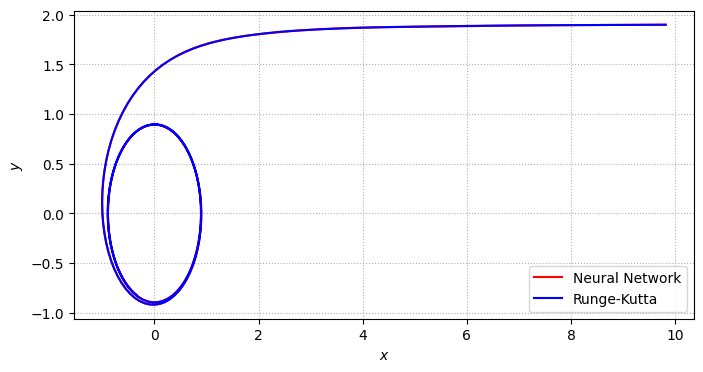

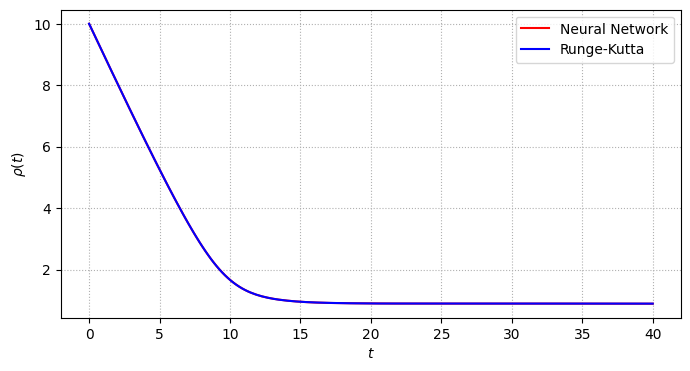

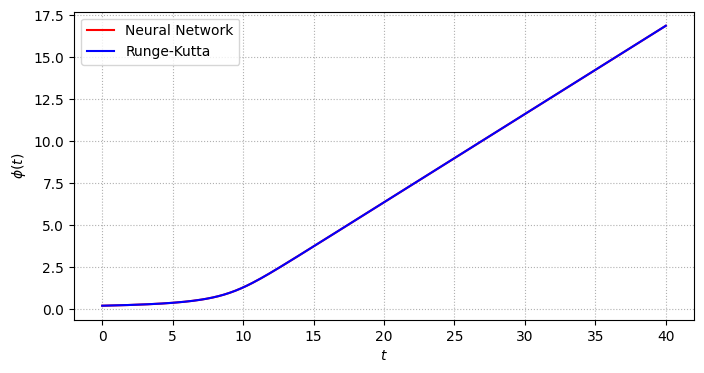

In [ ]:
# Let's plot and compare the results

plt.figure(figsize=(8,4))
plt.plot(x_nn,y_nn, ls='-', color='red', label='Neural Network')
plt.plot(x_num,y_num, ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(X_train,rho_nn, ls='-', color='red', label='Neural Network')
plt.plot(X_train,rho_num,ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel(r'$\rho(t)$')
plt.show()


plt.figure(figsize=(8,4))
plt.plot(X_train,phi_nn, ls = '-', color = 'red', label='Neural Network')
plt.plot(X_train,phi_num, ls = '-', color = 'blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$\phi(t)$')
plt.show()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_45 (Dense)            (None, 100)               200       
                                                                 
 tf_op_layer_Sin_30 (Tensor  multiple                  0         
 FlowOpLayer)                                                    
                                                                 
 dense_46 (Dense)            (None, 100)               10100     
                                                                 
 tf_op_layer_Sin_31 (Tensor  multiple                  0         
 FlowOpLayer)                                                    
                                                                 
 dense_47 (Dense)            (None, 2)                 202

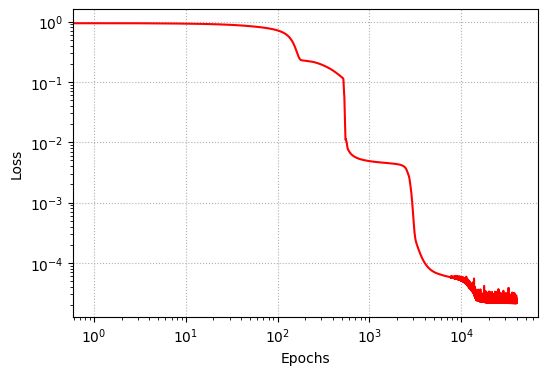

In [ ]:
#TRAINING

import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


import time
import numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import solve_ivp
from tensorflow import keras, Variable
from tensorflow.keras.optimizers import SGD, RMSprop, Nadam, Adagrad
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU, Concatenate
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import Conv1D, Conv2D,  UpSampling2D, Conv1DTranspose, MaxPool1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.python.framework.ops import disable_eager_execution
import sys
disable_eager_execution()

def info(obj,name):
  print(name,' shape: ',np.shape(obj),' type: ',type(obj), '\n')

np.random.seed(1)
keras.utils.set_random_seed(812)       #c'è differenza tra questi due comandi? La prima funzione fissa il seme della generazione dei numeri pseudocasuali su numpy,
                                       #il secondo serve per inizializzare in modo randomico i parametri della rete. Fissando il seme si fa in modo che ogni volta che
                                       #si ripete il codice i parametri iniziali della rete siano gli stessi

def scheduler(epoch, lr):              #si noti che in ingresso alla funzione si ha lr perchè questa funzione viene chiamata durante il training della rete dove viene usato lr:
                                       #per le prime 5000 epoche è uguale a lri, ma dopo di esse viene fatto diminuire con la legge riportata nell'else
  if epoch <= 5000:
    lr = lri
  else:
    lr = lr/(1+0.00001*epoch)
  return lr

#### Geodesic Parameters
L  = 1
af = 0.1
b  = 1.89

#### Integration Parameters
rho_0   = 10
phi_0   = np.arcsin(b/rho_0)
t_start = 0
t_final = 80
npoints = 50
t_eval  = np.linspace(t_start,t_final,npoints)

if b==1.9:
  def rad(rho):
    # return -(rho**2 + af**2)*tf.math.sqrt(0.000000000000000000000000000000000001+tf.math.abs((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2)))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
    return -(rho**2 + af**2)*tf.math.sqrt(-1.0)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

else:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def ang(rho):
  return (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def f(t):
  return 1 - tf.math.exp(-t)

def df(t):
  return tf.math.exp(-t)

def custom_activation(x):
  return tf.math.sin(x)



def custom_loss(t,N):

  def loss(y_true, y_pred):         #questo è un trucco per far fare alla rete ciò che ci serve: lei legge, come argomento della funzione loss, y_true e y_pred, quando a noi
                                    #interessa che la loss dipenda da N e t. Allora, facciamo restituire dalla funzione custom_loss la funzione loss, che è quella che la rete
                                    #"riconosce", ma visto che in ingresso a custum_loss ci sono N e t, questi entrano nella loss calcolata e minimizzata poi (durante il training)
                                    #dalla rete, ottenendo il nostro obiettivo
    ft  = f(t)
    dft = df(t)

    with tf.GradientTape() as tape:
      tape.watch(t)
      predictions = model(t,training=False)                   #è equivalente a model.predict? No, prima va allenata e dopo predice con model.predict
    gradients     = tape.batch_jacobian(predictions,t)        #vorrei capire meglio. La spiegazione è che sembra che con tape.gradient si calcolino le derivate dell'output
                                                              #rispetto a t e poi vengano sommate tutte le derivate, invece con batch_jacobian le derivate non vengano
                                                              #sommate ed è ciò che vogliamo
    gradients     = tf.reshape(gradients, (-1,2))

    rho             = rho_0+ft[:,0]*N[:,0]
    phi             = phi_0+ft[:,0]*N[:,1]

    rho_dot          = ft[:,0]*gradients[:,0] + dft[:,0]*N[:,0]
    phi_dot          = ft[:,0]*gradients[:,1] + dft[:,0]*N[:,1]

    eq1sep           = tf.square(rho_dot - rad(rho))
    eq2sep           = tf.square(phi_dot - ang(rho))
    total_loss_sep    = eq1sep  +  eq2sep

    return tf.reduce_mean(total_loss_sep)                #qui viene restituita come loss la media dei valori assunti da essa ai diversi tempi (quindi questo è il valore della loss
                                                     #alla data epoca)

  return loss     #questa loss è la funzione di sopra, quella riconosciuta dalla rete

# initial condition
z0  = np.array([rho_0,phi_0])

arc     = 'arc1'
lri     = 2e-4
X_train = t_eval # np.array([ [0], [0.5] ])
Y_train = np.zeros(len(X_train))

initializer  = 'random_normal'                    #l'inizializzatore serve a generare casualmente i parametri della rete e qui viene fatto con una distribuzione normale
opt          =  Adam(learning_rate=lri)

csv_logger   = CSVLogger(f'loss.dat', append=False, separator=' ')   #Questa callback serve a scrivere su un file il valore della loss a ogni epoca volta per volta
my_callbacks = [csv_logger]

if arc == 'arc1':                                 #ricordo che qui viene impostata l'architettura della rete
  input_layer = Input(shape=(1))
  branch = Dense(100, kernel_initializer=initializer)(input_layer)
  branch = custom_activation(branch)
  branch = Dense(100, kernel_initializer=initializer)(branch)
  branch = custom_activation(branch)
  output_layer = Dense(2, kernel_initializer=initializer)(branch)



model  = Model( inputs = input_layer , outputs = output_layer)    #qui invece viene impostato il modello
model.compile( loss=custom_loss(input_layer,output_layer), optimizer = opt )   #e qui viene compilato

model.summary()
# param = model.count_params()

EPOCHS  = 40000

start_time = time.time()
print(f'Training with {EPOCHS} epochs ...')
history = model.fit( x = X_train, y = None, epochs=EPOCHS, verbose = 0,batch_size = len(X_train), callbacks = [my_callbacks]) #qui invece viene fatto il training, ossia la minimizzazione della loss alle
                                                                                                                              #varie epoche. Avremmo potuto mettere y=Y_train, essendo comunque tutti 0.

print(f'Elapsed time = {time.time()-start_time} sec = {(time.time()-start_time)/60} min')

# Plot Loss Function
loss_1 = history.history['loss']     #grazie alla callback csv_logger, potremmo vedere come va la loss alle varie epoche senza aspettare tutto il training, cosa invece necessaria
                                     #con history.history
plt.figure(figsize=(6,4))
plt.plot(loss_1,color='red')
plt.yscale('log')
plt.xscale('log')
plt.grid(0.5,ls='dotted')
plt.xlabel('Epochs')
plt.ylabel('Loss')


# Prediction
prediction = model.predict(X_train)
solution = []
for n in range(len(prediction)):
  z = z0 + (1-np.exp(-X_train[n]))* prediction[n]
  solution.append(z)
prediction = np.transpose(solution)
rho_nn = prediction[0]
phi_nn = prediction[1]
x_nn = rho_nn*np.cos(phi_nn)
y_nn = rho_nn*np.sin(phi_nn)




In [ ]:
# Numerical Integration via solve_ivp using Runge-Kutta method of order 5(4)
def system(t,y):

  rho, phi = y
  drho_dt = -(rho**2 + af**2)*np.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  dphi_dt = (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  return [drho_dt, dphi_dt]

num_sol = solve_ivp(system, t_span=(t_eval[0],t_eval[-1]), y0=[rho_0,phi_0], t_eval = t_eval)
rho_num = num_sol.y[0]
phi_num = num_sol.y[1]
x_num = rho_num*np.cos(phi_num)
y_num = rho_num*np.sin(phi_num)

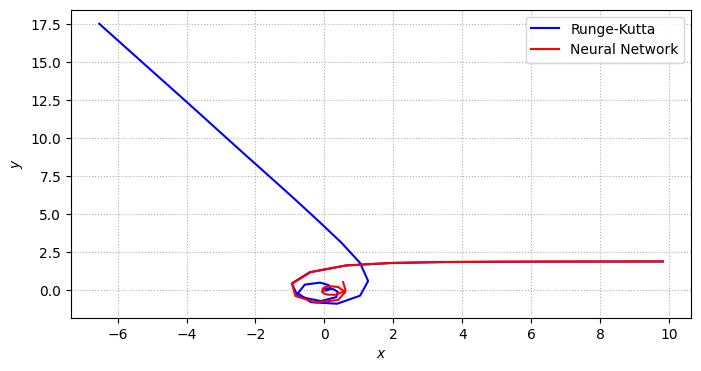

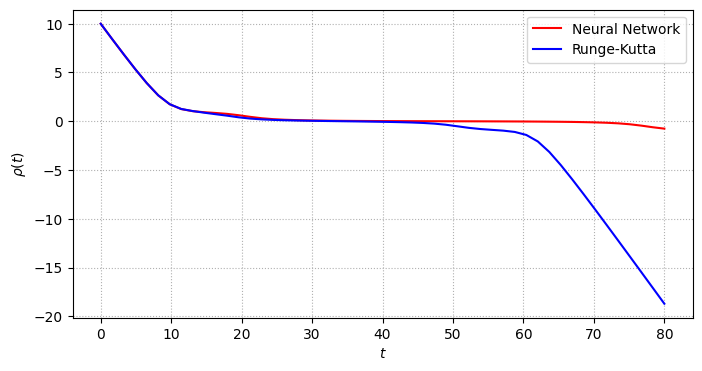

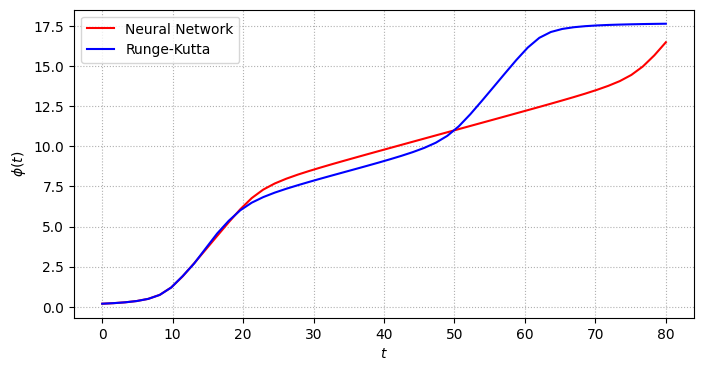

In [ ]:
# Let's plot and compare the results
plt.figure(figsize=(8,4))
plt.plot(x_num,y_num, ls='-', color='blue', label='Runge-Kutta')
plt.plot(x_nn,y_nn, ls='-', color='red', label='Neural Network')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(X_train,rho_nn, ls='-', color='red', label='Neural Network')
plt.plot(X_train,rho_num,ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel(r'$\rho(t)$')
plt.show()


plt.figure(figsize=(8,4))
plt.plot(X_train,phi_nn, ls = '-', color = 'red', label='Neural Network')
plt.plot(X_train,phi_num, ls = '-', color = 'blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$\phi(t)$')
plt.show()

Training with 100000 epochs ...
Elapsed time = 403.460200548172 sec = 6.72433678706487 min


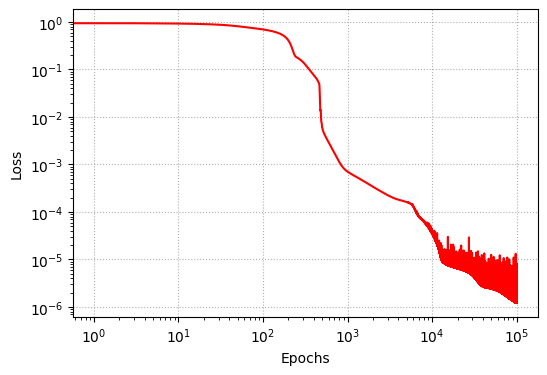

In [ ]:
#TRAINING

import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


import time
import numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import solve_ivp
from tensorflow import keras, Variable
from tensorflow.keras.optimizers import SGD, RMSprop, Nadam, Adagrad
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU, Concatenate
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import Conv1D, Conv2D,  UpSampling2D, Conv1DTranspose, MaxPool1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.python.framework.ops import disable_eager_execution
import sys
disable_eager_execution()

def info(obj,name):
  print(name,' shape: ',np.shape(obj),' type: ',type(obj), '\n')

np.random.seed(1)
keras.utils.set_random_seed(812)       #c'è differenza tra questi due comandi? La prima funzione fissa il seme della generazione dei numeri pseudocasuali su numpy,
                                       #il secondo serve per inizializzare in modo randomico i parametri della rete. Fissando il seme si fa in modo che ogni volta che
                                       #si ripete il codice i parametri iniziali della rete siano gli stessi

def scheduler(epoch, lr):              #si noti che in ingresso alla funzione si ha lr perchè questa funzione viene chiamata durante il training della rete dove viene usato lr:
                                       #per le prime 5000 epoche è uguale a lri, ma dopo di esse viene fatto diminuire con la legge riportata nell'else
  if epoch <= 5000:
    lr = lri
  else:
    lr = lr/(1+0.00001*epoch)
  return lr

#### Geodesic Parameters
L  = 1
af = 0.1
b  = 1.9

#### Integration Parameters
rho_0   = 10
phi_0   = 0
t_start = 0
t_final = 40
npoints = 200
t_eval  = np.linspace(t_start,t_final,npoints)

if b==1.9:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt(0.000000000000000000000000000000000001+tf.math.abs((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2)))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
else:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def ang(rho):
  return (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def f(t):
  return 1 - tf.math.exp(-t)

def df(t):
  return tf.math.exp(-t)

def custom_activation(x):
  return tf.math.sin(x)



def custom_loss(t,N):

  def loss(y_true, y_pred):         #questo è un trucco per far fare alla rete ciò che ci serve: lei legge, come argomento della funzione loss, y_true e y_pred, quando a noi
                                    #interessa che la loss dipenda da N e t. Allora, facciamo restituire dalla funzione custom_loss la funzione loss, che è quella che la rete
                                    #"riconosce", ma visto che in ingresso a custum_loss ci sono N e t, questi entrano nella loss calcolata e minimizzata poi (durante il training)
                                    #dalla rete, ottenendo il nostro obiettivo
    ft  = f(t)
    dft = df(t)

    with tf.GradientTape() as tape:
      tape.watch(t)
      predictions = model(t,training=False)                   #è equivalente a model.predict? No, prima va allenata e dopo predice con model.predict
    gradients     = tape.batch_jacobian(predictions,t)        #vorrei capire meglio. La spiegazione è che sembra che con tape.gradient si calcolino le derivate dell'output
                                                              #rispetto a t e poi vengano sommate tutte le derivate, invece con batch_jacobian le derivate non vengano
                                                              #sommate ed è ciò che vogliamo
    gradients     = tf.reshape(gradients, (-1,2))

    rho             = rho_0+ft[:,0]*N[:,0]
    phi             = phi_0+ft[:,0]*N[:,1]

    rho_dot          = ft[:,0]*gradients[:,0] + dft[:,0]*N[:,0]
    phi_dot          = ft[:,0]*gradients[:,1] + dft[:,0]*N[:,1]

    eq1sep           = tf.square(rho_dot - rad(rho))
    eq2sep           = tf.square(phi_dot - ang(rho))
    total_loss_sep    = eq1sep  +  eq2sep

    return tf.reduce_mean(total_loss_sep)                #qui viene restituita come loss la media dei valori assunti da essa ai diversi tempi (quindi questo è il valore della loss
                                                     #alla data epoca)

  return loss     #questa loss è la funzione di sopra, quella riconosciuta dalla rete

# initial condition
z0  = np.array([rho_0,phi_0])

arc     = 'arc1'
lri     = 4e-4
X_train = t_eval # np.array([ [0], [0.5] ])
Y_train = np.zeros(len(X_train))

initializer  = 'random_normal'                    #l'inizializzatore serve a generare casualmente i parametri della rete e qui viene fatto con una distribuzione normale
opt          =  Adam(learning_rate=lri)

csv_logger   = CSVLogger(f'loss.dat', append=False, separator=' ')   #Questa callback serve a scrivere su un file il valore della loss a ogni epoca volta per volta
my_callbacks = [csv_logger]

if arc == 'arc1':                                 #ricordo che qui viene impostata l'architettura della rete
  input_layer = Input(shape=(1))
  branch = Dense(50, kernel_initializer=initializer)(input_layer)
  branch = custom_activation(branch)
  branch = Dense(50, kernel_initializer=initializer)(branch)
  branch = custom_activation(branch)
  output_layer = Dense(2, kernel_initializer=initializer)(branch)



model  = Model( inputs = input_layer , outputs = output_layer)    #qui invece viene impostato il modello
model.compile( loss=custom_loss(input_layer,output_layer), optimizer = opt )   #e qui viene compilato

# model.summary()
# param = model.count_params()

EPOCHS  = 100000

start_time = time.time()
print(f'Training with {EPOCHS} epochs ...')
history = model.fit( x = X_train, y = None, epochs=EPOCHS, verbose = 0,batch_size = len(X_train), callbacks = [my_callbacks]) #qui invece viene fatto il training, ossia la minimizzazione della loss alle
                                                                                                                              #varie epoche. Avremmo potuto mettere y=Y_train, essendo comunque tutti 0.

print(f'Elapsed time = {time.time()-start_time} sec = {(time.time()-start_time)/60} min')

# Plot Loss Function
loss_1 = history.history['loss']     #grazie alla callback csv_logger, potremmo vedere come va la loss alle varie epoche senza aspettare tutto il training, cosa invece necessaria
                                     #con history.history
plt.figure(figsize=(6,4))
plt.plot(loss_1,color='red')
plt.yscale('log')
plt.xscale('log')
plt.grid(0.5,ls='dotted')
plt.xlabel('Epochs')
plt.ylabel('Loss')


# Prediction
prediction = model.predict(X_train)
solution = []
for n in range(len(prediction)):
  z = z0 + (1-np.exp(-X_train[n]))* prediction[n]
  solution.append(z)
prediction = np.transpose(solution)
rho_nn = prediction[0]
phi_nn = prediction[1]
x_nn = rho_nn*np.cos(phi_nn)
y_nn = rho_nn*np.sin(phi_nn)


In [ ]:
# Numerical Integration via solve_ivp using Runge-Kutta method of order 5(4)
def system(t,y):
  rho, phi = y
  drho_dt = -(rho**2 + af**2)*np.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  dphi_dt = (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  return [drho_dt, dphi_dt]

num_sol = solve_ivp(system, t_span=(t_eval[0],t_eval[-1]), y0=[rho_0,phi_0], t_eval = t_eval)
rho_num = num_sol.y[0]
phi_num = num_sol.y[1]
x_num = rho_num*np.cos(phi_num)
y_num = rho_num*np.sin(phi_num)

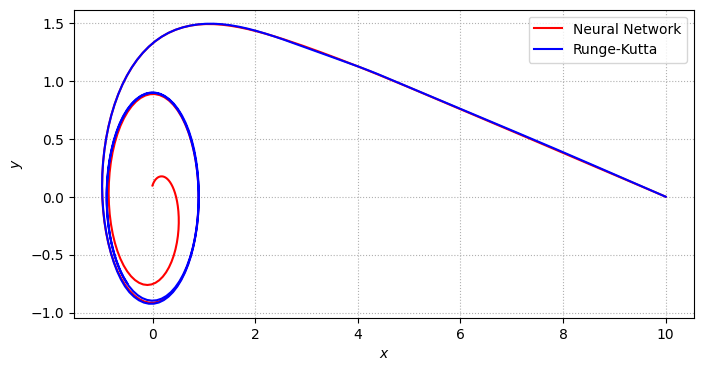

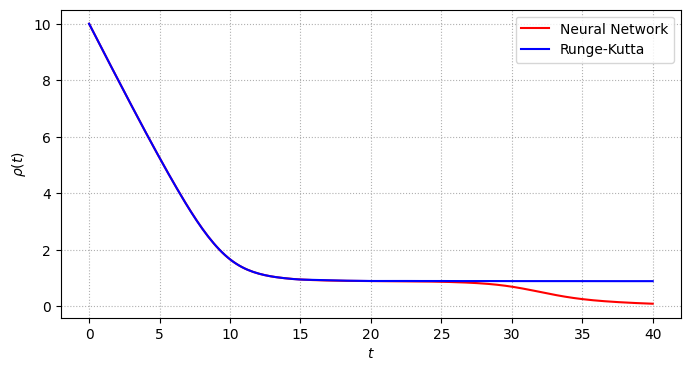

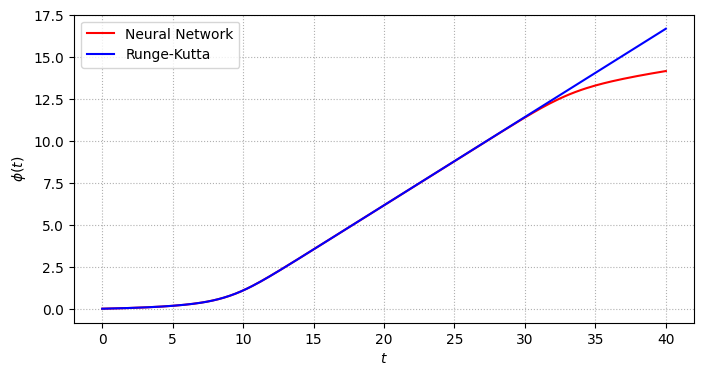

In [ ]:
# Let's plot and compare the results

plt.figure(figsize=(8,4))
plt.plot(x_nn,y_nn, ls='-', color='red', label='Neural Network')
plt.plot(x_num,y_num, ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(X_train,rho_nn, ls='-', color='red', label='Neural Network')
plt.plot(X_train,rho_num,ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel(r'$\rho(t)$')
plt.show()


plt.figure(figsize=(8,4))
plt.plot(X_train,phi_nn, ls = '-', color = 'red', label='Neural Network')
plt.plot(X_train,phi_num, ls = '-', color = 'blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$\phi(t)$')
plt.show()

Training with 100000 epochs ...
Elapsed time = 410.4235987663269 sec = 6.840393424034119 min


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


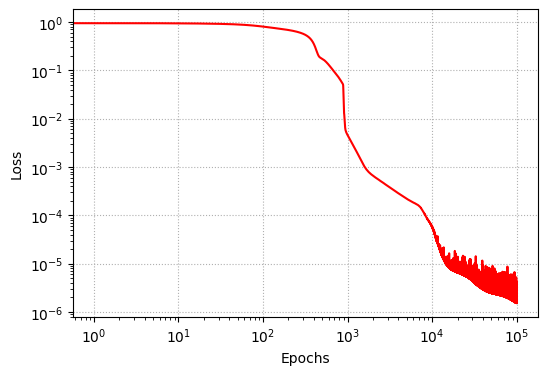

In [ ]:
#TRAINING

import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


import time
import numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import solve_ivp
from tensorflow import keras, Variable
from tensorflow.keras.optimizers import SGD, RMSprop, Nadam, Adagrad
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU, Concatenate
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import Conv1D, Conv2D,  UpSampling2D, Conv1DTranspose, MaxPool1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.python.framework.ops import disable_eager_execution
import sys
disable_eager_execution()

def info(obj,name):
  print(name,' shape: ',np.shape(obj),' type: ',type(obj), '\n')

np.random.seed(1)
keras.utils.set_random_seed(812)       #c'è differenza tra questi due comandi? La prima funzione fissa il seme della generazione dei numeri pseudocasuali su numpy,
                                       #il secondo serve per inizializzare in modo randomico i parametri della rete. Fissando il seme si fa in modo che ogni volta che
                                       #si ripete il codice i parametri iniziali della rete siano gli stessi

def scheduler(epoch, lr):              #si noti che in ingresso alla funzione si ha lr perchè questa funzione viene chiamata durante il training della rete dove viene usato lr:
                                       #per le prime 5000 epoche è uguale a lri, ma dopo di esse viene fatto diminuire con la legge riportata nell'else
  if epoch <= 5000:
    lr = lri
  else:
    lr = lr/(1+0.00001*epoch)
  return lr

#### Geodesic Parameters
L  = 1
af = 0.1
b  = 1.9

#### Integration Parameters
rho_0   = 10
phi_0   = 0
t_start = 0
t_final = 40
npoints = 200
t_eval  = np.linspace(t_start,t_final,npoints)

if b==1.9:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt(0.000000000000000000000000000000000001+tf.math.abs((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2)))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
else:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def ang(rho):
  return (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def f(t):
  return 1 - tf.math.exp(-t)

def df(t):
  return tf.math.exp(-t)

def custom_activation(x):
  return tf.math.sin(x)



def custom_loss(t,N):

  def loss(y_true, y_pred):         #questo è un trucco per far fare alla rete ciò che ci serve: lei legge, come argomento della funzione loss, y_true e y_pred, quando a noi
                                    #interessa che la loss dipenda da N e t. Allora, facciamo restituire dalla funzione custom_loss la funzione loss, che è quella che la rete
                                    #"riconosce", ma visto che in ingresso a custum_loss ci sono N e t, questi entrano nella loss calcolata e minimizzata poi (durante il training)
                                    #dalla rete, ottenendo il nostro obiettivo
    ft  = f(t)
    dft = df(t)

    with tf.GradientTape() as tape:
      tape.watch(t)
      predictions = model(t,training=False)                   #è equivalente a model.predict? No, prima va allenata e dopo predice con model.predict
    gradients     = tape.batch_jacobian(predictions,t)        #vorrei capire meglio. La spiegazione è che sembra che con tape.gradient si calcolino le derivate dell'output
                                                              #rispetto a t e poi vengano sommate tutte le derivate, invece con batch_jacobian le derivate non vengano
                                                              #sommate ed è ciò che vogliamo
    gradients     = tf.reshape(gradients, (-1,2))

    rho             = rho_0+ft[:,0]*N[:,0]
    phi             = phi_0+ft[:,0]*N[:,1]

    rho_dot          = ft[:,0]*gradients[:,0] + dft[:,0]*N[:,0]
    phi_dot          = ft[:,0]*gradients[:,1] + dft[:,0]*N[:,1]

    eq1sep           = tf.square(rho_dot - rad(rho))
    eq2sep           = tf.square(phi_dot - ang(rho))
    total_loss_sep    = eq1sep  +  eq2sep

    return tf.reduce_mean(total_loss_sep)                #qui viene restituita come loss la media dei valori assunti da essa ai diversi tempi (quindi questo è il valore della loss
                                                     #alla data epoca)

  return loss     #questa loss è la funzione di sopra, quella riconosciuta dalla rete

# initial condition
z0  = np.array([rho_0,phi_0])

arc     = 'arc1'
lri     = 2e-4
X_train = t_eval # np.array([ [0], [0.5] ])
Y_train = np.zeros(len(X_train))

initializer  = 'random_normal'                    #l'inizializzatore serve a generare casualmente i parametri della rete e qui viene fatto con una distribuzione normale
opt          =  Adam(learning_rate=lri)

csv_logger   = CSVLogger(f'loss.dat', append=False, separator=' ')   #Questa callback serve a scrivere su un file il valore della loss a ogni epoca volta per volta
my_callbacks = [csv_logger]

if arc == 'arc1':                                 #ricordo che qui viene impostata l'architettura della rete
  input_layer = Input(shape=(1))
  branch = Dense(50, kernel_initializer=initializer)(input_layer)
  branch = custom_activation(branch)
  branch = Dense(50, kernel_initializer=initializer)(branch)
  branch = custom_activation(branch)
  output_layer = Dense(2, kernel_initializer=initializer)(branch)



model  = Model( inputs = input_layer , outputs = output_layer)    #qui invece viene impostato il modello
model.compile( loss=custom_loss(input_layer,output_layer), optimizer = opt )   #e qui viene compilato

# model.summary()
# param = model.count_params()

EPOCHS  = 100000

start_time = time.time()
print(f'Training with {EPOCHS} epochs ...')
history = model.fit( x = X_train, y = None, epochs=EPOCHS, verbose = 0,batch_size = len(X_train), callbacks = [my_callbacks]) #qui invece viene fatto il training, ossia la minimizzazione della loss alle
                                                                                                                              #varie epoche. Avremmo potuto mettere y=Y_train, essendo comunque tutti 0.

print(f'Elapsed time = {time.time()-start_time} sec = {(time.time()-start_time)/60} min')

# Plot Loss Function
loss_1 = history.history['loss']     #grazie alla callback csv_logger, potremmo vedere come va la loss alle varie epoche senza aspettare tutto il training, cosa invece necessaria
                                     #con history.history
plt.figure(figsize=(6,4))
plt.plot(loss_1,color='red')
plt.yscale('log')
plt.xscale('log')
plt.grid(0.5,ls='dotted')
plt.xlabel('Epochs')
plt.ylabel('Loss')


# Prediction
prediction = model.predict(X_train)
solution = []
for n in range(len(prediction)):
  z = z0 + (1-np.exp(-X_train[n]))* prediction[n]
  solution.append(z)
prediction = np.transpose(solution)
rho_nn = prediction[0]
phi_nn = prediction[1]
x_nn = rho_nn*np.cos(phi_nn)
y_nn = rho_nn*np.sin(phi_nn)


In [ ]:
# Numerical Integration via solve_ivp using Runge-Kutta method of order 5(4)
def system(t,y):
  rho, phi = y
  drho_dt = -(rho**2 + af**2)*np.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  dphi_dt = (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  return [drho_dt, dphi_dt]

num_sol = solve_ivp(system, t_span=(t_eval[0],t_eval[-1]), y0=[rho_0,phi_0], t_eval = t_eval)
rho_num = num_sol.y[0]
phi_num = num_sol.y[1]
x_num = rho_num*np.cos(phi_num)
y_num = rho_num*np.sin(phi_num)

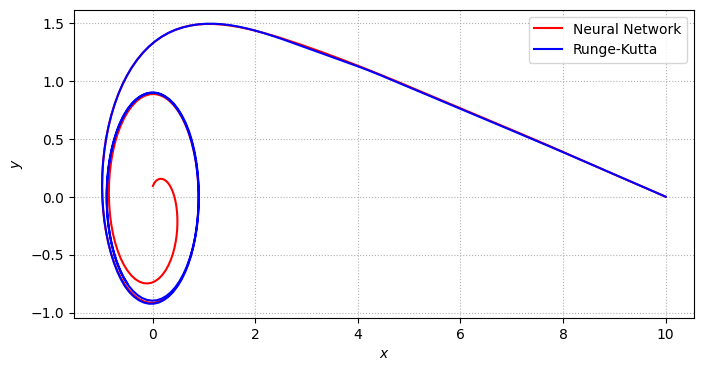

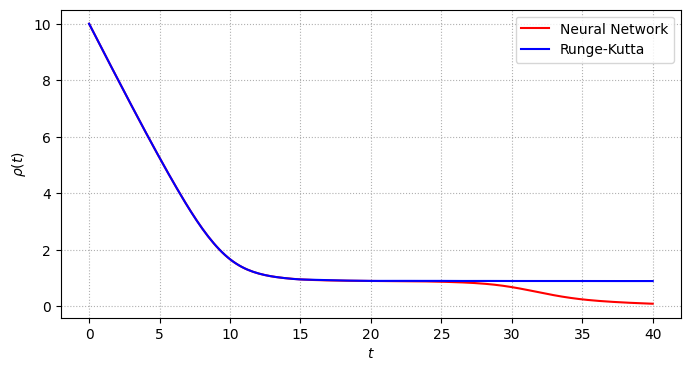

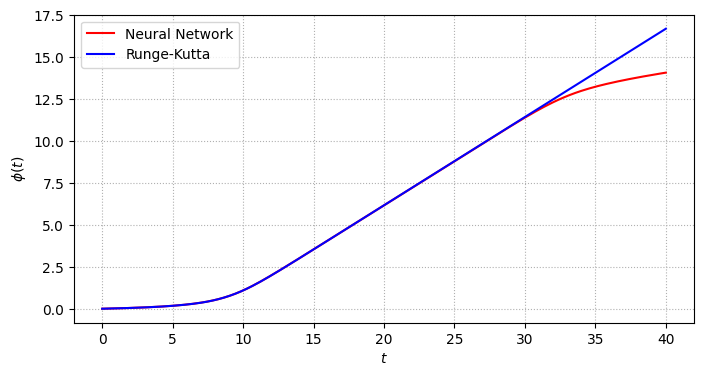

In [ ]:
# Let's plot and compare the results

plt.figure(figsize=(8,4))
plt.plot(x_nn,y_nn, ls='-', color='red', label='Neural Network')
plt.plot(x_num,y_num, ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(X_train,rho_nn, ls='-', color='red', label='Neural Network')
plt.plot(X_train,rho_num,ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel(r'$\rho(t)$')
plt.show()


plt.figure(figsize=(8,4))
plt.plot(X_train,phi_nn, ls = '-', color = 'red', label='Neural Network')
plt.plot(X_train,phi_num, ls = '-', color = 'blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$\phi(t)$')
plt.show()

Training with 10000 epochs ...
Elapsed time = 35.327035427093506 sec = 0.5887840310732524 min


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Training with 10000 epochs ...
Elapsed time = 42.21081590652466 sec = 0.7035137057304383 min
Training with 10000 epochs ...
Elapsed time = 51.24174404144287 sec = 0.8540291825930277 min


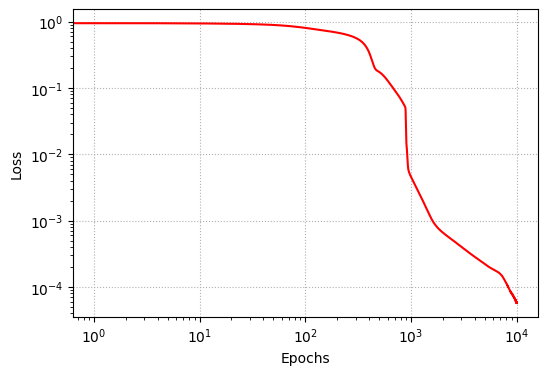

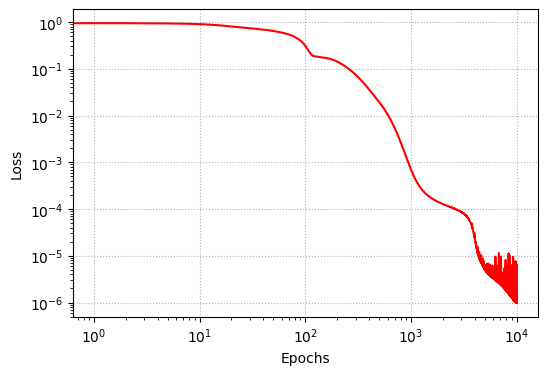

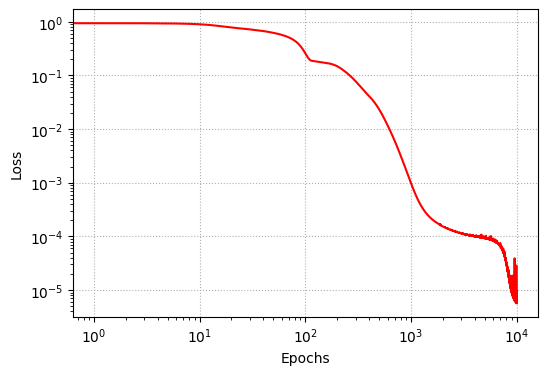

In [ ]:
#TRAINING

import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


import time
import numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import solve_ivp
from tensorflow import keras, Variable
from tensorflow.keras.optimizers import SGD, RMSprop, Nadam, Adagrad
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU, Concatenate
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import Conv1D, Conv2D,  UpSampling2D, Conv1DTranspose, MaxPool1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.python.framework.ops import disable_eager_execution
import sys
disable_eager_execution()

def info(obj,name):
  print(name,' shape: ',np.shape(obj),' type: ',type(obj), '\n')

np.random.seed(1)
keras.utils.set_random_seed(812)       #c'è differenza tra questi due comandi? La prima funzione fissa il seme della generazione dei numeri pseudocasuali su numpy,
                                       #il secondo serve per inizializzare in modo randomico i parametri della rete. Fissando il seme si fa in modo che ogni volta che
                                       #si ripete il codice i parametri iniziali della rete siano gli stessi

def scheduler(epoch, lr):              #si noti che in ingresso alla funzione si ha lr perchè questa funzione viene chiamata durante il training della rete dove viene usato lr:
                                       #per le prime 5000 epoche è uguale a lri, ma dopo di esse viene fatto diminuire con la legge riportata nell'else
  if epoch <= 5000:
    lr = lri
  else:
    lr = lr/(1+0.00001*epoch)
  return lr

#### Geodesic Parameters
L  = 1
af = 0.1
b  = 1.9

#### Integration Parameters
rho_0   = 10
phi_0   = 0
t_start = 0
t_final = 40
npoints = 200
t_eval  = np.linspace(t_start,t_final,npoints)
EPOCHS  = 10000

if b==1.9:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt(0.000000000000000000000000000000000001+tf.math.abs((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2)))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
else:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def ang(rho):
  return (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def f(t):
  return 1 - tf.math.exp(-t)

def df(t):
  return tf.math.exp(-t)

def custom_activation(x):
  return tf.math.sin(x)



def custom_loss(t,N):

  def loss(y_true, y_pred):         #questo è un trucco per far fare alla rete ciò che ci serve: lei legge, come argomento della funzione loss, y_true e y_pred, quando a noi
                                    #interessa che la loss dipenda da N e t. Allora, facciamo restituire dalla funzione custom_loss la funzione loss, che è quella che la rete
                                    #"riconosce", ma visto che in ingresso a custum_loss ci sono N e t, questi entrano nella loss calcolata e minimizzata poi (durante il training)
                                    #dalla rete, ottenendo il nostro obiettivo
    ft  = f(t)
    dft = df(t)

    with tf.GradientTape() as tape:
      tape.watch(t)
      predictions = model(t,training=False)                   #è equivalente a model.predict? No, prima va allenata e dopo predice con model.predict
    gradients     = tape.batch_jacobian(predictions,t)        #vorrei capire meglio. La spiegazione è che sembra che con tape.gradient si calcolino le derivate dell'output
                                                              #rispetto a t e poi vengano sommate tutte le derivate, invece con batch_jacobian le derivate non vengano
                                                              #sommate ed è ciò che vogliamo
    gradients     = tf.reshape(gradients, (-1,2))

    rho             = rho_0+ft[:,0]*N[:,0]
    phi             = phi_0+ft[:,0]*N[:,1]

    rho_dot          = ft[:,0]*gradients[:,0] + dft[:,0]*N[:,0]
    phi_dot          = ft[:,0]*gradients[:,1] + dft[:,0]*N[:,1]

    eq1sep           = tf.square(rho_dot - rad(rho))
    eq2sep           = tf.square(phi_dot - ang(rho))
    total_loss_sep    = eq1sep  +  eq2sep

    return tf.reduce_mean(total_loss_sep)                #qui viene restituita come loss la media dei valori assunti da essa ai diversi tempi (quindi questo è il valore della loss
                                                     #alla data epoca)

  return loss     #questa loss è la funzione di sopra, quella riconosciuta dalla rete

# initial condition
z0  = np.array([rho_0,phi_0])

architectures = ['arc2l','arc3l','arc4l']

lri     = 2e-4
X_train = t_eval # np.array([ [0], [0.5] ])
Y_train = np.zeros(len(X_train))
rho_nn_tot = [np.zeros(len(X_train)),np.zeros(len(X_train)),np.zeros(len(X_train))]
phi_nn_tot = [np.zeros(len(X_train)),np.zeros(len(X_train)),np.zeros(len(X_train))]
x_nn_tot = [np.zeros(len(X_train)),np.zeros(len(X_train)),np.zeros(len(X_train))]
y_nn_tot = [np.zeros(len(X_train)),np.zeros(len(X_train)),np.zeros(len(X_train))]
i = 0

initializer  = 'random_normal'                    #l'inizializzatore serve a generare casualmente i parametri della rete e qui viene fatto con una distribuzione normale
opt          =  Adam(learning_rate=lri)

csv_logger   = CSVLogger(f'loss.dat', append=False, separator=' ')   #Questa callback serve a scrivere su un file il valore della loss a ogni epoca volta per volta
my_callbacks = [csv_logger]


for arc in architectures:
  if arc == 'arc2l':
    input_layer = Input(shape=(1))
    branch = Dense(50, kernel_initializer=initializer)(input_layer)
    branch = custom_activation(branch)
    branch = Dense(50, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    output_layer = Dense(2, kernel_initializer=initializer)(branch)
  elif arc == 'arc3l':
    input_layer = Input(shape=(1))
    branch = Dense(50, kernel_initializer=initializer)(input_layer)
    branch = custom_activation(branch)
    branch = Dense(50, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    branch = Dense(50, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    output_layer = Dense(2, kernel_initializer=initializer)(branch)
  else:
    input_layer = Input(shape=(1))
    branch = Dense(50, kernel_initializer=initializer)(input_layer)
    branch = custom_activation(branch)
    branch = Dense(50, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    branch = Dense(50, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    branch = Dense(50, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    output_layer = Dense(2, kernel_initializer=initializer)(branch)

  model  = Model( inputs = input_layer , outputs = output_layer)    #qui invece viene impostato il modello
  model.compile( loss=custom_loss(input_layer,output_layer), optimizer = opt )   #e qui viene compilato

# model.summary()
# param = model.count_params()


  start_time = time.time()
  print(f'Training with {EPOCHS} epochs ...')
  history = model.fit( x = X_train, y = None, epochs=EPOCHS, verbose = 0,batch_size = len(X_train), callbacks = [my_callbacks]) #qui invece viene fatto il training, ossia la minimizzazione della loss alle
                                                                                                                              #varie epoche. Avremmo potuto mettere y=Y_train, essendo comunque tutti 0.

  print(f'Elapsed time = {time.time()-start_time} sec = {(time.time()-start_time)/60} min')

  # Plot Loss Function
  loss_1 = history.history['loss']     #grazie alla callback csv_logger, potremmo vedere come va la loss alle varie epoche senza aspettare tutto il training, cosa invece necessaria
                                     #con history.history
  plt.figure(figsize=(6,4))
  plt.plot(loss_1,color='red')
  plt.yscale('log')
  plt.xscale('log')
  plt.grid(0.5,ls='dotted')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')


  # Prediction
  prediction = model.predict(X_train)
  solution = []
  for n in range(len(prediction)):
    z = z0 + (1-np.exp(-X_train[n]))* prediction[n]
    solution.append(z)
  prediction = np.transpose(solution)
  rho_nn_tot[i] = prediction[0]
  phi_nn_tot[i] = prediction[1]
  x_nn_tot[i] = rho_nn_tot[i]*np.cos(phi_nn_tot[i])
  y_nn_tot[i] = rho_nn_tot[i]*np.sin(phi_nn_tot[i])
  i+=1


Training with 100000 epochs ...
Elapsed time = 345.28554487228394 sec = 5.754759204387665 min


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Training with 100000 epochs ...
Elapsed time = 344.2392690181732 sec = 5.737321269512177 min
Training with 100000 epochs ...
Elapsed time = 439.39950156211853 sec = 7.323325177033742 min


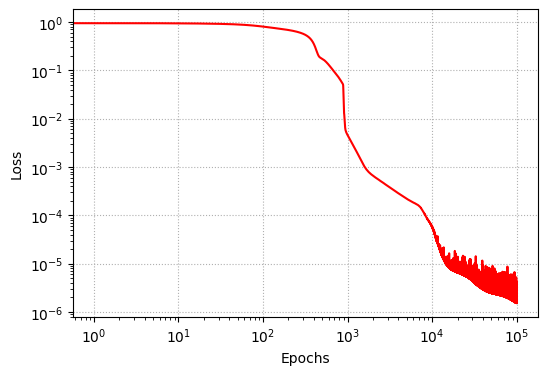

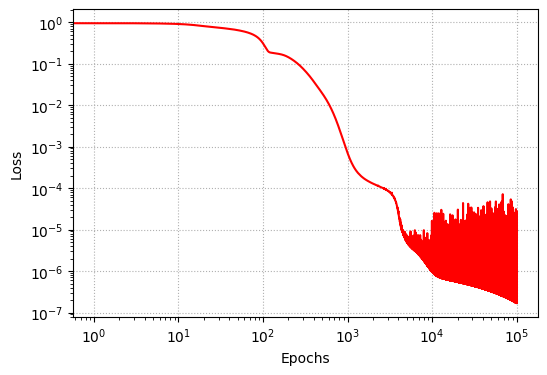

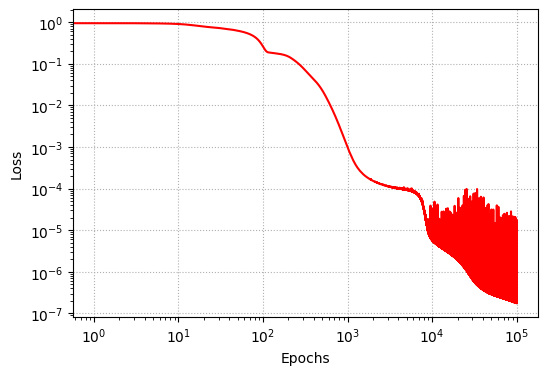

In [ ]:
#TRAINING

import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


import time
import numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import solve_ivp
from tensorflow import keras, Variable
from tensorflow.keras.optimizers import SGD, RMSprop, Nadam, Adagrad
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU, Concatenate
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import Conv1D, Conv2D,  UpSampling2D, Conv1DTranspose, MaxPool1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.python.framework.ops import disable_eager_execution
import sys
disable_eager_execution()

def info(obj,name):
  print(name,' shape: ',np.shape(obj),' type: ',type(obj), '\n')

np.random.seed(1)
keras.utils.set_random_seed(812)       #c'è differenza tra questi due comandi? La prima funzione fissa il seme della generazione dei numeri pseudocasuali su numpy,
                                       #il secondo serve per inizializzare in modo randomico i parametri della rete. Fissando il seme si fa in modo che ogni volta che
                                       #si ripete il codice i parametri iniziali della rete siano gli stessi

def scheduler(epoch, lr):              #si noti che in ingresso alla funzione si ha lr perchè questa funzione viene chiamata durante il training della rete dove viene usato lr:
                                       #per le prime 5000 epoche è uguale a lri, ma dopo di esse viene fatto diminuire con la legge riportata nell'else
  if epoch <= 5000:
    lr = lri
  else:
    lr = lr/(1+0.00001*epoch)
  return lr

#### Geodesic Parameters
L  = 1
af = 0.1
b  = 1.9

#### Integration Parameters
rho_0   = 10
phi_0   = 0
t_start = 0
t_final = 40
npoints = 200
t_eval  = np.linspace(t_start,t_final,npoints)
EPOCHS  = 100000

if b==1.9:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt(0.000000000000000000000000000000000001+tf.math.abs((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2)))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
else:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def ang(rho):
  return (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def f(t):
  return 1 - tf.math.exp(-t)

def df(t):
  return tf.math.exp(-t)

def custom_activation(x):
  return tf.math.sin(x)



def custom_loss(t,N):

  def loss(y_true, y_pred):         #questo è un trucco per far fare alla rete ciò che ci serve: lei legge, come argomento della funzione loss, y_true e y_pred, quando a noi
                                    #interessa che la loss dipenda da N e t. Allora, facciamo restituire dalla funzione custom_loss la funzione loss, che è quella che la rete
                                    #"riconosce", ma visto che in ingresso a custum_loss ci sono N e t, questi entrano nella loss calcolata e minimizzata poi (durante il training)
                                    #dalla rete, ottenendo il nostro obiettivo
    ft  = f(t)
    dft = df(t)

    with tf.GradientTape() as tape:
      tape.watch(t)
      predictions = model(t,training=False)                   #è equivalente a model.predict? No, prima va allenata e dopo predice con model.predict
    gradients     = tape.batch_jacobian(predictions,t)        #vorrei capire meglio. La spiegazione è che sembra che con tape.gradient si calcolino le derivate dell'output
                                                              #rispetto a t e poi vengano sommate tutte le derivate, invece con batch_jacobian le derivate non vengano
                                                              #sommate ed è ciò che vogliamo
    gradients     = tf.reshape(gradients, (-1,2))

    rho             = rho_0+ft[:,0]*N[:,0]
    phi             = phi_0+ft[:,0]*N[:,1]

    rho_dot          = ft[:,0]*gradients[:,0] + dft[:,0]*N[:,0]
    phi_dot          = ft[:,0]*gradients[:,1] + dft[:,0]*N[:,1]

    eq1sep           = tf.square(rho_dot - rad(rho))
    eq2sep           = tf.square(phi_dot - ang(rho))
    total_loss_sep    = eq1sep  +  eq2sep

    return tf.reduce_mean(total_loss_sep)                #qui viene restituita come loss la media dei valori assunti da essa ai diversi tempi (quindi questo è il valore della loss
                                                     #alla data epoca)

  return loss     #questa loss è la funzione di sopra, quella riconosciuta dalla rete

# initial condition
z0  = np.array([rho_0,phi_0])

architectures = ['arc2l','arc3l','arc4l']

lri     = 2e-4
X_train = t_eval # np.array([ [0], [0.5] ])
Y_train = np.zeros(len(X_train))
rho_nn_tot = [np.zeros(len(X_train)),np.zeros(len(X_train)),np.zeros(len(X_train))]
phi_nn_tot = [np.zeros(len(X_train)),np.zeros(len(X_train)),np.zeros(len(X_train))]
x_nn_tot = [np.zeros(len(X_train)),np.zeros(len(X_train)),np.zeros(len(X_train))]
y_nn_tot = [np.zeros(len(X_train)),np.zeros(len(X_train)),np.zeros(len(X_train))]
i = 0

initializer  = 'random_normal'                    #l'inizializzatore serve a generare casualmente i parametri della rete e qui viene fatto con una distribuzione normale
opt          =  Adam(learning_rate=lri)

csv_logger   = CSVLogger(f'loss.dat', append=False, separator=' ')   #Questa callback serve a scrivere su un file il valore della loss a ogni epoca volta per volta
my_callbacks = [csv_logger]


for arc in architectures:
  if arc == 'arc2l':
    input_layer = Input(shape=(1))
    branch = Dense(50, kernel_initializer=initializer)(input_layer)
    branch = custom_activation(branch)
    branch = Dense(50, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    output_layer = Dense(2, kernel_initializer=initializer)(branch)
  elif arc == 'arc3l':
    input_layer = Input(shape=(1))
    branch = Dense(50, kernel_initializer=initializer)(input_layer)
    branch = custom_activation(branch)
    branch = Dense(50, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    branch = Dense(50, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    output_layer = Dense(2, kernel_initializer=initializer)(branch)
  else:
    input_layer = Input(shape=(1))
    branch = Dense(50, kernel_initializer=initializer)(input_layer)
    branch = custom_activation(branch)
    branch = Dense(50, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    branch = Dense(50, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    branch = Dense(50, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    output_layer = Dense(2, kernel_initializer=initializer)(branch)

  model  = Model( inputs = input_layer , outputs = output_layer)    #qui invece viene impostato il modello
  model.compile( loss=custom_loss(input_layer,output_layer), optimizer = opt )   #e qui viene compilato

# model.summary()
# param = model.count_params()


  start_time = time.time()
  print(f'Training with {EPOCHS} epochs ...')
  history = model.fit( x = X_train, y = None, epochs=EPOCHS, verbose = 0,batch_size = len(X_train), callbacks = [my_callbacks]) #qui invece viene fatto il training, ossia la minimizzazione della loss alle
                                                                                                                              #varie epoche. Avremmo potuto mettere y=Y_train, essendo comunque tutti 0.

  print(f'Elapsed time = {time.time()-start_time} sec = {(time.time()-start_time)/60} min')

  # Plot Loss Function
  loss_1 = history.history['loss']     #grazie alla callback csv_logger, potremmo vedere come va la loss alle varie epoche senza aspettare tutto il training, cosa invece necessaria
                                     #con history.history
  plt.figure(figsize=(6,4))
  plt.plot(loss_1,color='red')
  plt.yscale('log')
  plt.xscale('log')
  plt.grid(0.5,ls='dotted')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')


  # Prediction
  prediction = model.predict(X_train)
  solution = []
  for n in range(len(prediction)):
    z = z0 + (1-np.exp(-X_train[n]))* prediction[n]
    solution.append(z)
  prediction = np.transpose(solution)
  rho_nn_tot[i] = prediction[0]
  phi_nn_tot[i] = prediction[1]
  x_nn_tot[i] = rho_nn_tot[i]*np.cos(phi_nn_tot[i])
  y_nn_tot[i] = rho_nn_tot[i]*np.sin(phi_nn_tot[i])
  i+=1


In [ ]:
from scipy.integrate import solve_ivp

# Numerical Integration via solve_ivp using Runge-Kutta method of order 5(4)
def system(t,y):
  rho, phi = y
  drho_dt = -(rho**2 + af**2)*np.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  dphi_dt = (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  return [drho_dt, dphi_dt]

num_sol = solve_ivp(system, t_span=(t_eval[0],t_eval[-1]), y0=[rho_0,phi_0], t_eval = t_eval)
rho_num = num_sol.y[0]
phi_num = num_sol.y[1]
x_num = rho_num*np.cos(phi_num)
y_num = rho_num*np.sin(phi_num)

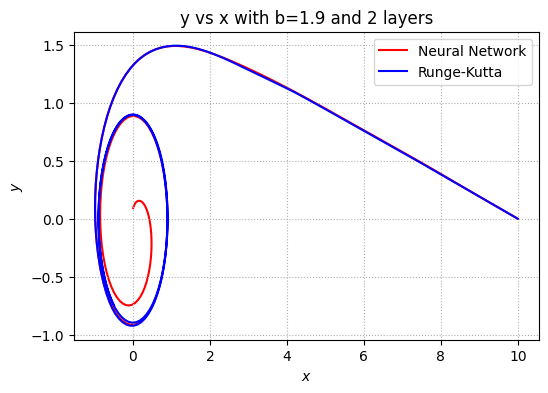

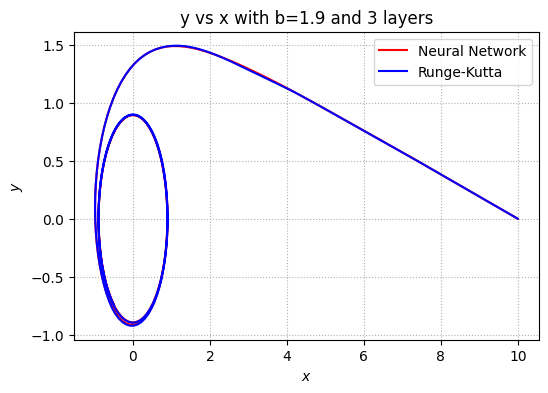

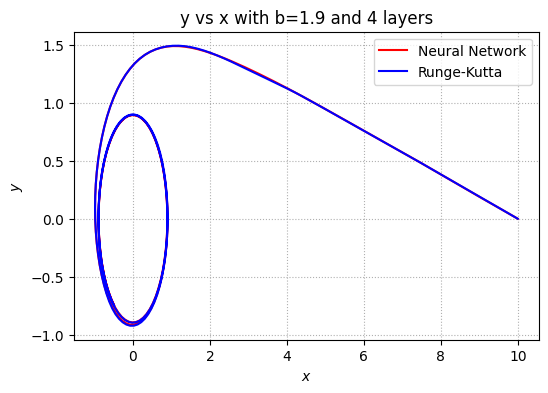

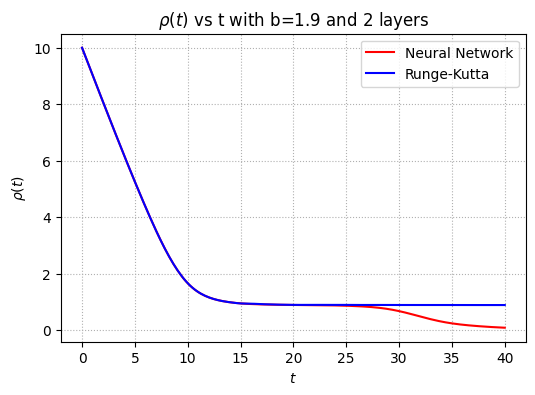

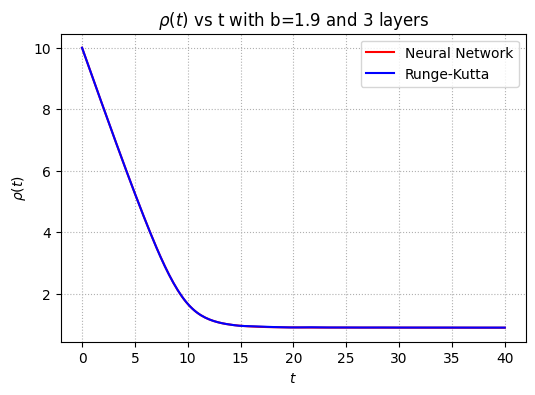

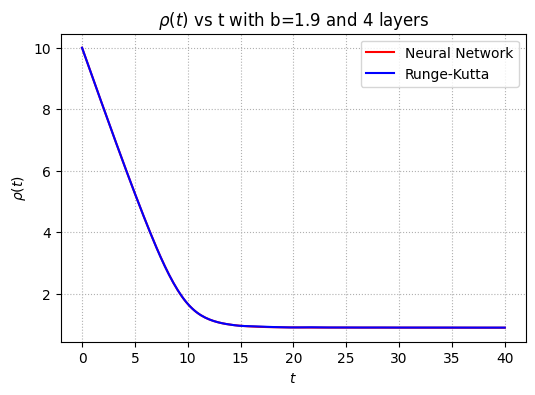

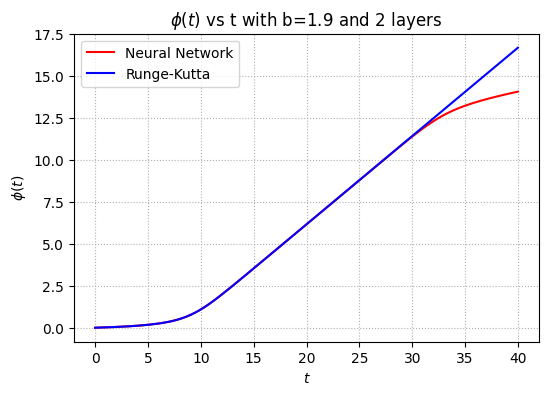

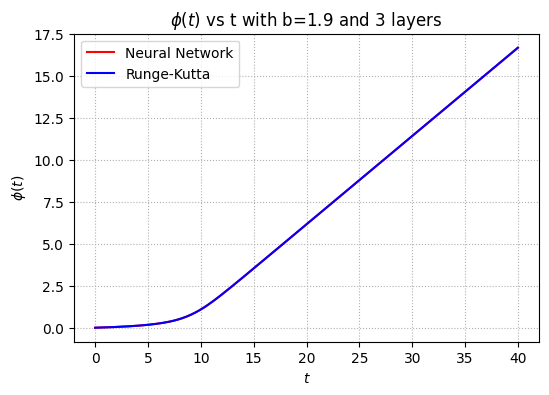

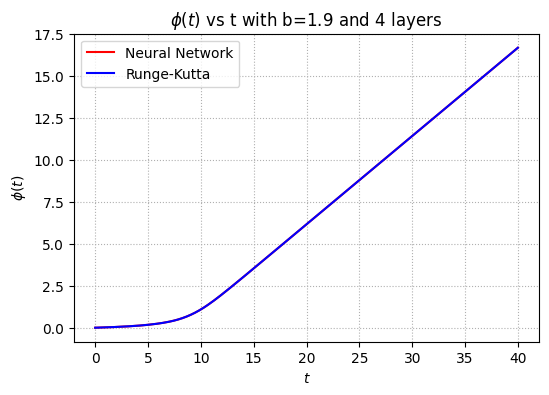

In [ ]:
# Let's plot and compare the results

plt.figure(figsize=(6,4))
plt.title('y vs x with b=1.9 and 2 layers')
plt.plot(x_nn_tot[0],y_nn_tot[0], ls='-', color='red', label='Neural Network',zorder=1)
plt.plot(x_num,y_num, ls='-', color='blue', label='Runge-Kutta',zorder=2)
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.figure(figsize=(6,4))
plt.title('y vs x with b=1.9 and 3 layers')
plt.plot(x_nn_tot[1],y_nn_tot[1], ls='-', color='red', label='Neural Network')
plt.plot(x_num,y_num, ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.figure(figsize=(6,4))
plt.title('y vs x with b=1.9 and 4 layers')
plt.plot(x_nn_tot[2],y_nn_tot[2], ls='-', color='red', label='Neural Network')
plt.plot(x_num,y_num, ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.figure(figsize=(6,4))
plt.title(r'$\rho(t)$ vs t with b=1.9 and 2 layers')
plt.plot(X_train,rho_nn_tot[0], ls='-', color='red', label='Neural Network')
plt.plot(X_train,rho_num,ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel(r'$\rho(t)$')
plt.show()

plt.figure(figsize=(6,4))
plt.title(r'$\rho(t)$ vs t with b=1.9 and 3 layers')
plt.plot(X_train,rho_nn_tot[1], ls='-', color='red', label='Neural Network')
plt.plot(X_train,rho_num,ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel(r'$\rho(t)$')
plt.show()

plt.figure(figsize=(6,4))
plt.title(r'$\rho(t)$ vs t with b=1.9 and 4 layers')
plt.plot(X_train,rho_nn_tot[2], ls='-', color='red', label='Neural Network')
plt.plot(X_train,rho_num,ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel(r'$\rho(t)$')
plt.show()


plt.figure(figsize=(6,4))
plt.title('$\phi(t)$ vs t with b=1.9 and 2 layers')
plt.plot(X_train,phi_nn_tot[0], ls = '-', color = 'red', label='Neural Network')
plt.plot(X_train,phi_num, ls = '-', color = 'blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$\phi(t)$')
plt.show()

plt.figure(figsize=(6,4))
plt.title('$\phi(t)$ vs t with b=1.9 and 3 layers')
plt.plot(X_train,phi_nn_tot[1], ls = '-', color = 'red', label='Neural Network')
plt.plot(X_train,phi_num, ls = '-', color = 'blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$\phi(t)$')
plt.show()

plt.figure(figsize=(6,4))
plt.title('$\phi(t)$ vs t with b=1.9 and 4 layers')
plt.plot(X_train,phi_nn_tot[2], ls = '-', color = 'red', label='Neural Network')
plt.plot(X_train,phi_num, ls = '-', color = 'blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$\phi(t)$')
plt.show()

Training with 100000 epochs ...
Elapsed time = 280.5735046863556 sec = 4.676225197315216 min


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Training with 100000 epochs ...
Elapsed time = 221.4733669757843 sec = 3.691222898165385 min
Training with 100000 epochs ...
Elapsed time = 249.27719402313232 sec = 4.154620047410329 min


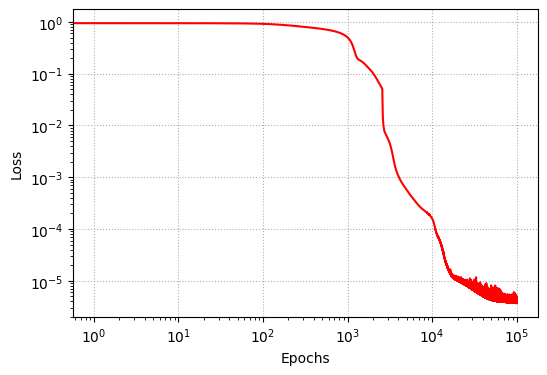

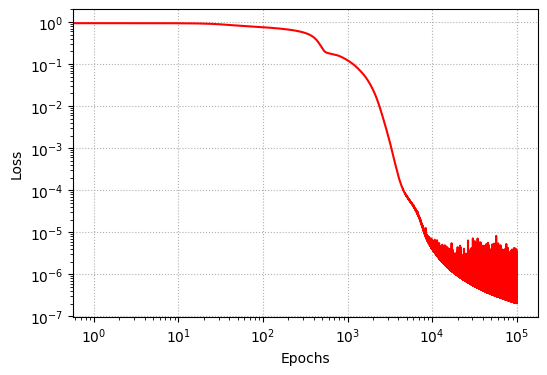

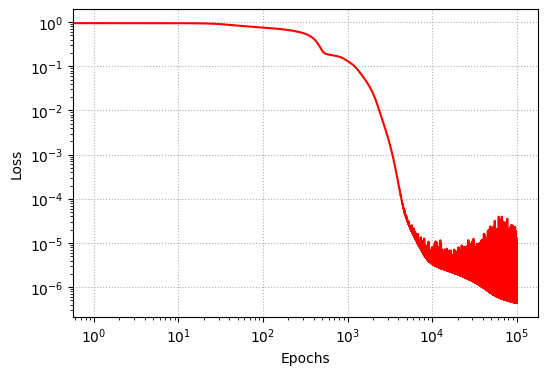

In [ ]:
#TRAINING

import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


import time
import numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import solve_ivp
from tensorflow import keras, Variable
from tensorflow.keras.optimizers import SGD, RMSprop, Nadam, Adagrad
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU, Concatenate
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import Conv1D, Conv2D,  UpSampling2D, Conv1DTranspose, MaxPool1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.python.framework.ops import disable_eager_execution
import sys
disable_eager_execution()

def info(obj,name):
  print(name,' shape: ',np.shape(obj),' type: ',type(obj), '\n')

np.random.seed(1)
keras.utils.set_random_seed(812)       #c'è differenza tra questi due comandi? La prima funzione fissa il seme della generazione dei numeri pseudocasuali su numpy,
                                       #il secondo serve per inizializzare in modo randomico i parametri della rete. Fissando il seme si fa in modo che ogni volta che
                                       #si ripete il codice i parametri iniziali della rete siano gli stessi

def scheduler(epoch, lr):              #si noti che in ingresso alla funzione si ha lr perchè questa funzione viene chiamata durante il training della rete dove viene usato lr:
                                       #per le prime 5000 epoche è uguale a lri, ma dopo di esse viene fatto diminuire con la legge riportata nell'else
  if epoch <= 5000:
    lr = lri
  else:
    lr = lr/(1+0.00001*epoch)
  return lr

#### Geodesic Parameters
L  = 1
af = 0.1
b  = 1.9

#### Integration Parameters
rho_0   = 10
phi_0   = 0
t_start = 0
t_final = 40
npoints = 200
t_eval  = np.linspace(t_start,t_final,npoints)
EPOCHS  = 100000

if b==1.9:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt(0.000000000000000000000000000000000001+tf.math.abs((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2)))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
else:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def ang(rho):
  return (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def f(t):
  return 1 - tf.math.exp(-t)

def df(t):
  return tf.math.exp(-t)

def custom_activation(x):
  return tf.math.sin(x)



def custom_loss(t,N):

  def loss(y_true, y_pred):         #questo è un trucco per far fare alla rete ciò che ci serve: lei legge, come argomento della funzione loss, y_true e y_pred, quando a noi
                                    #interessa che la loss dipenda da N e t. Allora, facciamo restituire dalla funzione custom_loss la funzione loss, che è quella che la rete
                                    #"riconosce", ma visto che in ingresso a custum_loss ci sono N e t, questi entrano nella loss calcolata e minimizzata poi (durante il training)
                                    #dalla rete, ottenendo il nostro obiettivo
    ft  = f(t)
    dft = df(t)

    with tf.GradientTape() as tape:
      tape.watch(t)
      predictions = model(t,training=False)                   #è equivalente a model.predict? No, prima va allenata e dopo predice con model.predict
    gradients     = tape.batch_jacobian(predictions,t)        #vorrei capire meglio. La spiegazione è che sembra che con tape.gradient si calcolino le derivate dell'output
                                                              #rispetto a t e poi vengano sommate tutte le derivate, invece con batch_jacobian le derivate non vengano
                                                              #sommate ed è ciò che vogliamo
    gradients     = tf.reshape(gradients, (-1,2))

    rho             = rho_0+ft[:,0]*N[:,0]
    phi             = phi_0+ft[:,0]*N[:,1]

    rho_dot          = ft[:,0]*gradients[:,0] + dft[:,0]*N[:,0]
    phi_dot          = ft[:,0]*gradients[:,1] + dft[:,0]*N[:,1]

    eq1sep           = tf.square(rho_dot - rad(rho))
    eq2sep           = tf.square(phi_dot - ang(rho))
    total_loss_sep    = eq1sep  +  eq2sep

    return tf.reduce_mean(total_loss_sep)                #qui viene restituita come loss la media dei valori assunti da essa ai diversi tempi (quindi questo è il valore della loss
                                                     #alla data epoca)

  return loss     #questa loss è la funzione di sopra, quella riconosciuta dalla rete

# initial condition
z0  = np.array([rho_0,phi_0])

architectures20n = ['arc2l20n','arc3l20n','arc4l20n']

lri     = 2e-4
X_train = t_eval # np.array([ [0], [0.5] ])
Y_train = np.zeros(len(X_train))
rho_nn_tot20n = [np.zeros(len(X_train)),np.zeros(len(X_train)),np.zeros(len(X_train))]
phi_nn_tot20n = [np.zeros(len(X_train)),np.zeros(len(X_train)),np.zeros(len(X_train))]
x_nn_tot20n = [np.zeros(len(X_train)),np.zeros(len(X_train)),np.zeros(len(X_train))]
y_nn_tot20n = [np.zeros(len(X_train)),np.zeros(len(X_train)),np.zeros(len(X_train))]
i = 0

initializer  = 'random_normal'                    #l'inizializzatore serve a generare casualmente i parametri della rete e qui viene fatto con una distribuzione normale
opt          =  Adam(learning_rate=lri)

csv_logger   = CSVLogger(f'loss.dat', append=False, separator=' ')   #Questa callback serve a scrivere su un file il valore della loss a ogni epoca volta per volta
my_callbacks = [csv_logger]


for arc in architectures20n:
  if arc == 'arc2l20n':
    input_layer = Input(shape=(1))
    branch = Dense(20, kernel_initializer=initializer)(input_layer)
    branch = custom_activation(branch)
    branch = Dense(20, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    output_layer = Dense(2, kernel_initializer=initializer)(branch)
  elif arc == 'arc3l20n':
    input_layer = Input(shape=(1))
    branch = Dense(20, kernel_initializer=initializer)(input_layer)
    branch = custom_activation(branch)
    branch = Dense(20, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    branch = Dense(20, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    output_layer = Dense(2, kernel_initializer=initializer)(branch)
  else:
    input_layer = Input(shape=(1))
    branch = Dense(20, kernel_initializer=initializer)(input_layer)
    branch = custom_activation(branch)
    branch = Dense(20, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    branch = Dense(20, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    branch = Dense(20, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    output_layer = Dense(2, kernel_initializer=initializer)(branch)

  model  = Model( inputs = input_layer , outputs = output_layer)    #qui invece viene impostato il modello
  model.compile( loss=custom_loss(input_layer,output_layer), optimizer = opt )   #e qui viene compilato

# model.summary()
# param = model.count_params()


  start_time = time.time()
  print(f'Training with {EPOCHS} epochs ...')
  history = model.fit( x = X_train, y = None, epochs=EPOCHS, verbose = 0,batch_size = len(X_train), callbacks = [my_callbacks]) #qui invece viene fatto il training, ossia la minimizzazione della loss alle
                                                                                                                              #varie epoche. Avremmo potuto mettere y=Y_train, essendo comunque tutti 0.

  print(f'Elapsed time = {time.time()-start_time} sec = {(time.time()-start_time)/60} min')

  # Plot Loss Function
  loss_1 = history.history['loss']     #grazie alla callback csv_logger, potremmo vedere come va la loss alle varie epoche senza aspettare tutto il training, cosa invece necessaria
                                     #con history.history
  plt.figure(figsize=(6,4))
  plt.plot(loss_1,color='red')
  plt.yscale('log')
  plt.xscale('log')
  plt.grid(0.5,ls='dotted')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')


  # Prediction
  prediction = model.predict(X_train)
  solution = []
  for n in range(len(prediction)):
    z = z0 + (1-np.exp(-X_train[n]))* prediction[n]
    solution.append(z)
  prediction = np.transpose(solution)
  rho_nn_tot20n[i] = prediction[0]
  phi_nn_tot20n[i] = prediction[1]
  x_nn_tot20n[i] = rho_nn_tot20n[i]*np.cos(phi_nn_tot20n[i])
  y_nn_tot20n[i] = rho_nn_tot20n[i]*np.sin(phi_nn_tot20n[i])
  i+=1


In [ ]:
# Numerical Integration via solve_ivp using Runge-Kutta method of order 5(4)
def system(t,y):
  rho, phi = y
  drho_dt = -(rho**2 + af**2)*np.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  dphi_dt = (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  return [drho_dt, dphi_dt]

num_sol = solve_ivp(system, t_span=(t_eval[0],t_eval[-1]), y0=[rho_0,phi_0], t_eval = t_eval)
rho_num = num_sol.y[0]
phi_num = num_sol.y[1]
x_num = rho_num*np.cos(phi_num)
y_num = rho_num*np.sin(phi_num)

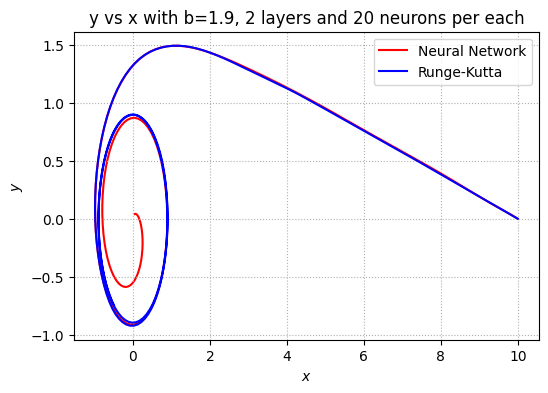

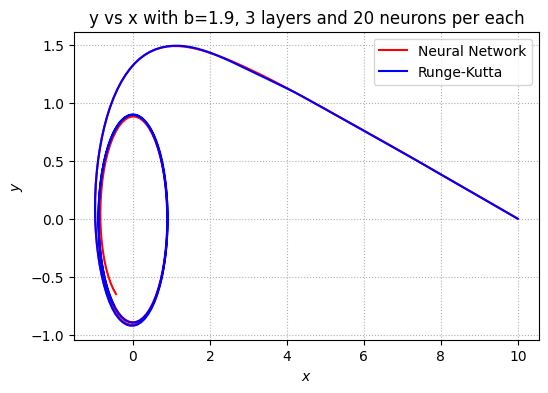

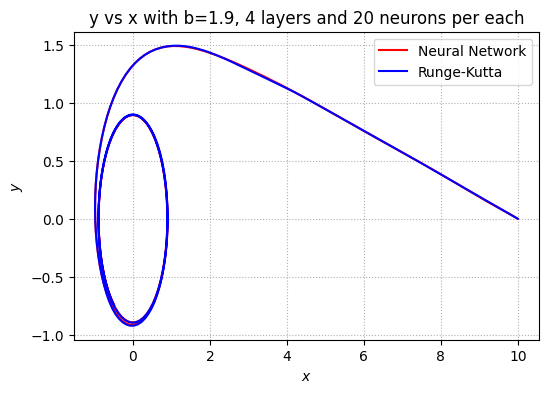

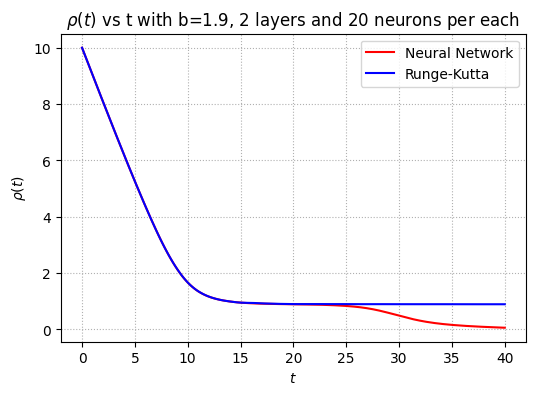

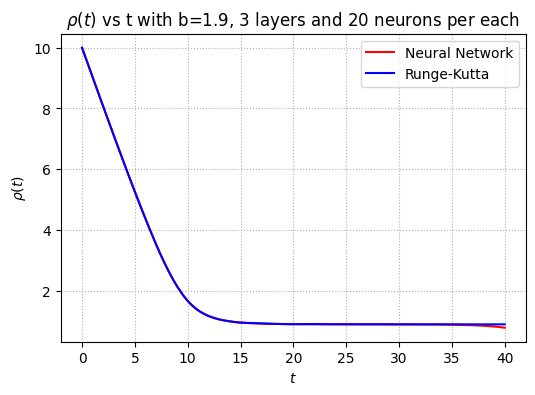

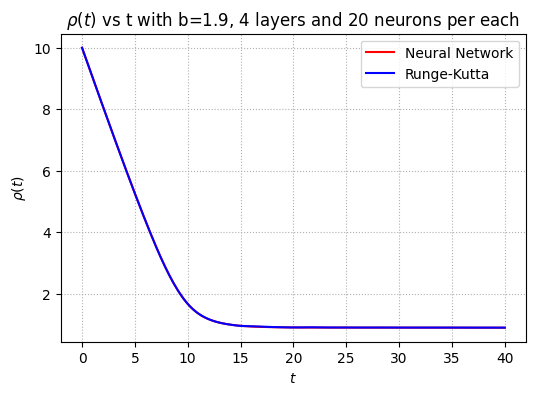

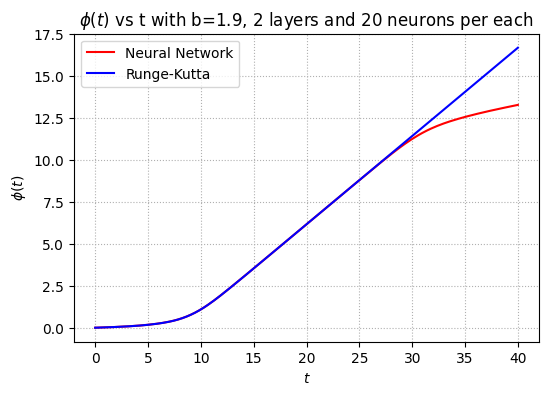

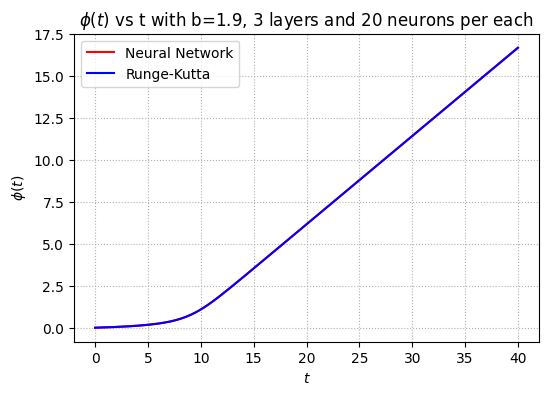

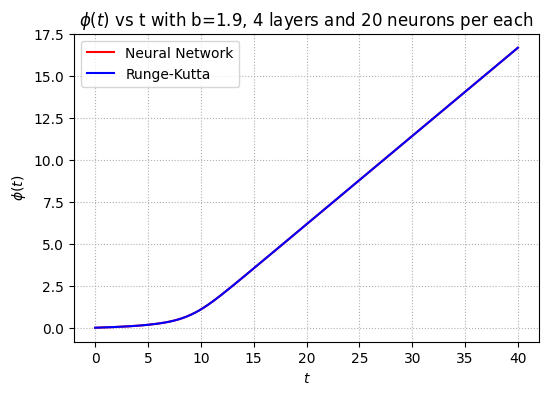

In [ ]:
# Let's plot and compare the results

plt.figure(figsize=(6,4))
plt.title('y vs x with b=1.9, 2 layers and 20 neurons per each')
plt.plot(x_nn_tot20n[0],y_nn_tot20n[0], ls='-', color='red', label='Neural Network',zorder=1)
plt.plot(x_num,y_num, ls='-', color='blue', label='Runge-Kutta',zorder=2)
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.figure(figsize=(6,4))
plt.title('y vs x with b=1.9, 3 layers and 20 neurons per each')
plt.plot(x_nn_tot20n[1],y_nn_tot20n[1], ls='-', color='red', label='Neural Network')
plt.plot(x_num,y_num, ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.figure(figsize=(6,4))
plt.title('y vs x with b=1.9, 4 layers and 20 neurons per each')
plt.plot(x_nn_tot20n[2],y_nn_tot20n[2], ls='-', color='red', label='Neural Network')
plt.plot(x_num,y_num, ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.figure(figsize=(6,4))
plt.title(r'$\rho(t)$ vs t with b=1.9, 2 layers and 20 neurons per each')
plt.plot(X_train,rho_nn_tot20n[0], ls='-', color='red', label='Neural Network')
plt.plot(X_train,rho_num,ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel(r'$\rho(t)$')
plt.show()

plt.figure(figsize=(6,4))
plt.title(r'$\rho(t)$ vs t with b=1.9, 3 layers and 20 neurons per each')
plt.plot(X_train,rho_nn_tot20n[1], ls='-', color='red', label='Neural Network')
plt.plot(X_train,rho_num,ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel(r'$\rho(t)$')
plt.show()

plt.figure(figsize=(6,4))
plt.title(r'$\rho(t)$ vs t with b=1.9, 4 layers and 20 neurons per each')
plt.plot(X_train,rho_nn_tot20n[2], ls='-', color='red', label='Neural Network')
plt.plot(X_train,rho_num,ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel(r'$\rho(t)$')
plt.show()


plt.figure(figsize=(6,4))
plt.title('$\phi(t)$ vs t with b=1.9, 2 layers and 20 neurons per each')
plt.plot(X_train,phi_nn_tot20n[0], ls = '-', color = 'red', label='Neural Network')
plt.plot(X_train,phi_num, ls = '-', color = 'blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$\phi(t)$')
plt.show()

plt.figure(figsize=(6,4))
plt.title('$\phi(t)$ vs t with b=1.9, 3 layers and 20 neurons per each')
plt.plot(X_train,phi_nn_tot20n[1], ls = '-', color = 'red', label='Neural Network')
plt.plot(X_train,phi_num, ls = '-', color = 'blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$\phi(t)$')
plt.show()

plt.figure(figsize=(6,4))
plt.title('$\phi(t)$ vs t with b=1.9, 4 layers and 20 neurons per each')
plt.plot(X_train,phi_nn_tot20n[2], ls = '-', color = 'red', label='Neural Network')
plt.plot(X_train,phi_num, ls = '-', color = 'blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$\phi(t)$')
plt.show()

Training with 100000 epochs ...
Elapsed time = 990.3543362617493 sec = 16.50590575536092 min


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Training with 100000 epochs ...
Elapsed time = 944.39213347435 sec = 15.73986903031667 min
Training with 100000 epochs ...
Elapsed time = 941.0142185688019 sec = 15.683570416768392 min


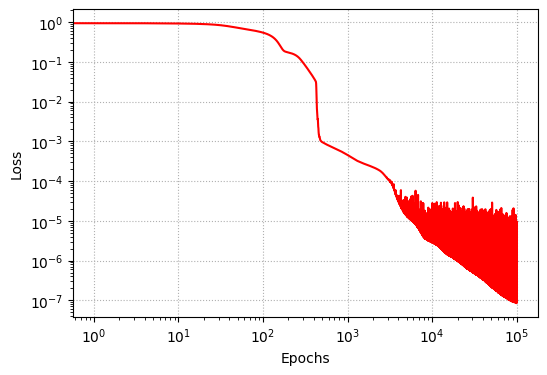

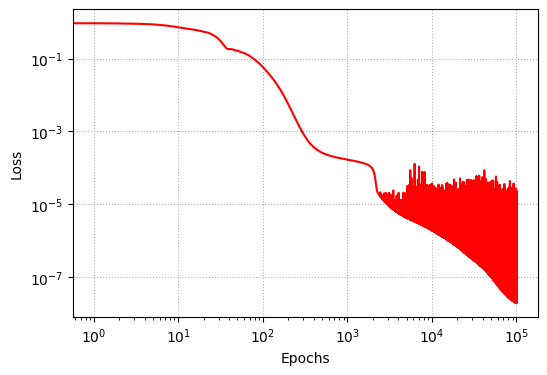

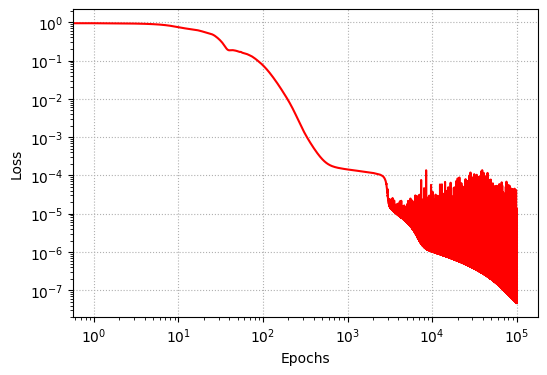

In [ ]:
#TRAINING

import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


import time
import numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import solve_ivp
from tensorflow import keras, Variable
from tensorflow.keras.optimizers import SGD, RMSprop, Nadam, Adagrad
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU, Concatenate
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import Conv1D, Conv2D,  UpSampling2D, Conv1DTranspose, MaxPool1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.python.framework.ops import disable_eager_execution
import sys
disable_eager_execution()

def info(obj,name):
  print(name,' shape: ',np.shape(obj),' type: ',type(obj), '\n')

np.random.seed(1)
keras.utils.set_random_seed(812)       #c'è differenza tra questi due comandi? La prima funzione fissa il seme della generazione dei numeri pseudocasuali su numpy,
                                       #il secondo serve per inizializzare in modo randomico i parametri della rete. Fissando il seme si fa in modo che ogni volta che
                                       #si ripete il codice i parametri iniziali della rete siano gli stessi

def scheduler(epoch, lr):              #si noti che in ingresso alla funzione si ha lr perchè questa funzione viene chiamata durante il training della rete dove viene usato lr:
                                       #per le prime 5000 epoche è uguale a lri, ma dopo di esse viene fatto diminuire con la legge riportata nell'else
  if epoch <= 5000:
    lr = lri
  else:
    lr = lr/(1+0.00001*epoch)
  return lr

#### Geodesic Parameters
L  = 1
af = 0.1
b  = 1.9

#### Integration Parameters
rho_0   = 10
phi_0   = 0
t_start = 0
t_final = 40
npoints = 200
t_eval  = np.linspace(t_start,t_final,npoints)
EPOCHS  = 100000

if b==1.9:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt(0.000000000000000000000000000000000001+tf.math.abs((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2)))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
else:
  def rad(rho):
    return -(rho**2 + af**2)*tf.math.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def ang(rho):
  return (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def f(t):
  return 1 - tf.math.exp(-t)

def df(t):
  return tf.math.exp(-t)

def custom_activation(x):
  return tf.math.sin(x)



def custom_loss(t,N):

  def loss(y_true, y_pred):         #questo è un trucco per far fare alla rete ciò che ci serve: lei legge, come argomento della funzione loss, y_true e y_pred, quando a noi
                                    #interessa che la loss dipenda da N e t. Allora, facciamo restituire dalla funzione custom_loss la funzione loss, che è quella che la rete
                                    #"riconosce", ma visto che in ingresso a custum_loss ci sono N e t, questi entrano nella loss calcolata e minimizzata poi (durante il training)
                                    #dalla rete, ottenendo il nostro obiettivo
    ft  = f(t)
    dft = df(t)

    with tf.GradientTape() as tape:
      tape.watch(t)
      predictions = model(t,training=False)                   #è equivalente a model.predict? No, prima va allenata e dopo predice con model.predict
    gradients     = tape.batch_jacobian(predictions,t)        #vorrei capire meglio. La spiegazione è che sembra che con tape.gradient si calcolino le derivate dell'output
                                                              #rispetto a t e poi vengano sommate tutte le derivate, invece con batch_jacobian le derivate non vengano
                                                              #sommate ed è ciò che vogliamo
    gradients     = tf.reshape(gradients, (-1,2))

    rho             = rho_0+ft[:,0]*N[:,0]
    phi             = phi_0+ft[:,0]*N[:,1]

    rho_dot          = ft[:,0]*gradients[:,0] + dft[:,0]*N[:,0]
    phi_dot          = ft[:,0]*gradients[:,1] + dft[:,0]*N[:,1]

    eq1sep           = tf.square(rho_dot - rad(rho))
    eq2sep           = tf.square(phi_dot - ang(rho))
    total_loss_sep    = eq1sep  +  eq2sep

    return tf.reduce_mean(total_loss_sep)                #qui viene restituita come loss la media dei valori assunti da essa ai diversi tempi (quindi questo è il valore della loss
                                                     #alla data epoca)

  return loss     #questa loss è la funzione di sopra, quella riconosciuta dalla rete

# initial condition
z0  = np.array([rho_0,phi_0])

architectures100n = ['arc2l100n','arc3l100n','arc4l100n']

lri     = 2e-4
X_train = t_eval # np.array([ [0], [0.5] ])
Y_train = np.zeros(len(X_train))
rho_nn_tot100n = [np.zeros(len(X_train)),np.zeros(len(X_train)),np.zeros(len(X_train))]
phi_nn_tot100n = [np.zeros(len(X_train)),np.zeros(len(X_train)),np.zeros(len(X_train))]
x_nn_tot100n = [np.zeros(len(X_train)),np.zeros(len(X_train)),np.zeros(len(X_train))]
y_nn_tot100n = [np.zeros(len(X_train)),np.zeros(len(X_train)),np.zeros(len(X_train))]
i = 0

initializer  = 'random_normal'                    #l'inizializzatore serve a generare casualmente i parametri della rete e qui viene fatto con una distribuzione normale
opt          =  Adam(learning_rate=lri)

csv_logger   = CSVLogger(f'loss.dat', append=False, separator=' ')   #Questa callback serve a scrivere su un file il valore della loss a ogni epoca volta per volta
my_callbacks = [csv_logger]


for arc in architectures20n:
  if arc == 'arc2l100n':
    input_layer = Input(shape=(1))
    branch = Dense(100, kernel_initializer=initializer)(input_layer)
    branch = custom_activation(branch)
    branch = Dense(100, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    output_layer = Dense(2, kernel_initializer=initializer)(branch)
  elif arc == 'arc3l100n':
    input_layer = Input(shape=(1))
    branch = Dense(100, kernel_initializer=initializer)(input_layer)
    branch = custom_activation(branch)
    branch = Dense(100, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    branch = Dense(100, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    output_layer = Dense(2, kernel_initializer=initializer)(branch)
  else:
    input_layer = Input(shape=(1))
    branch = Dense(100, kernel_initializer=initializer)(input_layer)
    branch = custom_activation(branch)
    branch = Dense(100, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    branch = Dense(100, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    branch = Dense(100, kernel_initializer=initializer)(branch)
    branch = custom_activation(branch)
    output_layer = Dense(2, kernel_initializer=initializer)(branch)

  model  = Model( inputs = input_layer , outputs = output_layer)    #qui invece viene impostato il modello
  model.compile( loss=custom_loss(input_layer,output_layer), optimizer = opt )   #e qui viene compilato

# model.summary()
# param = model.count_params()


  start_time = time.time()
  print(f'Training with {EPOCHS} epochs ...')
  history = model.fit( x = X_train, y = None, epochs=EPOCHS, verbose = 0,batch_size = len(X_train), callbacks = [my_callbacks]) #qui invece viene fatto il training, ossia la minimizzazione della loss alle
                                                                                                                              #varie epoche. Avremmo potuto mettere y=Y_train, essendo comunque tutti 0.

  print(f'Elapsed time = {time.time()-start_time} sec = {(time.time()-start_time)/60} min')

  # Plot Loss Function
  loss_1 = history.history['loss']     #grazie alla callback csv_logger, potremmo vedere come va la loss alle varie epoche senza aspettare tutto il training, cosa invece necessaria
                                     #con history.history
  plt.figure(figsize=(6,4))
  plt.plot(loss_1,color='red')
  plt.yscale('log')
  plt.xscale('log')
  plt.grid(0.5,ls='dotted')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')


  # Prediction
  prediction = model.predict(X_train)
  solution = []
  for n in range(len(prediction)):
    z = z0 + (1-np.exp(-X_train[n]))* prediction[n]
    solution.append(z)
  prediction = np.transpose(solution)
  rho_nn_tot100n[i] = prediction[0]
  phi_nn_tot100n[i] = prediction[1]
  x_nn_tot100n[i] = rho_nn_tot100n[i]*np.cos(phi_nn_tot100n[i])
  y_nn_tot100n[i] = rho_nn_tot100n[i]*np.sin(phi_nn_tot100n[i])
  i+=1


In [ ]:
# Numerical Integration via solve_ivp using Runge-Kutta method of order 5(4)
def system(t,y):
  rho, phi = y
  drho_dt = -(rho**2 + af**2)*np.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  dphi_dt = (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  return [drho_dt, dphi_dt]

num_sol = solve_ivp(system, t_span=(t_eval[0],t_eval[-1]), y0=[rho_0,phi_0], t_eval = t_eval)
rho_num = num_sol.y[0]
phi_num = num_sol.y[1]
x_num = rho_num*np.cos(phi_num)
y_num = rho_num*np.sin(phi_num)

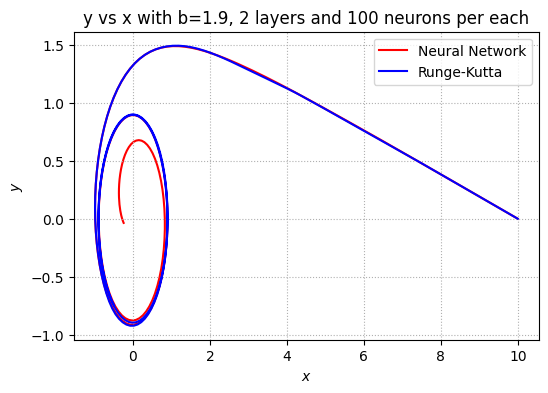

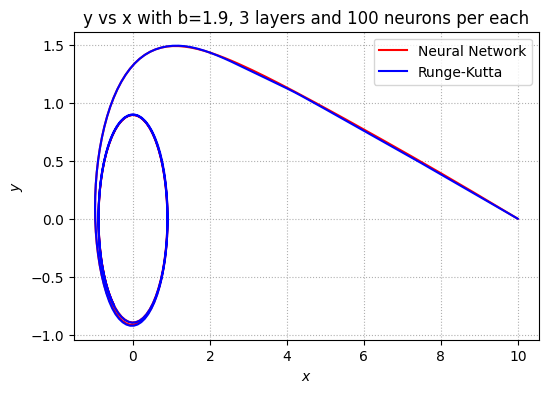

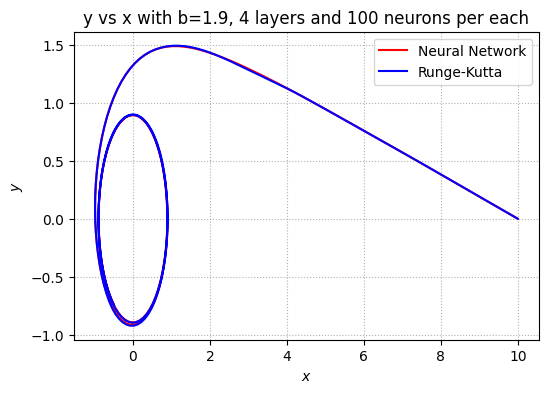

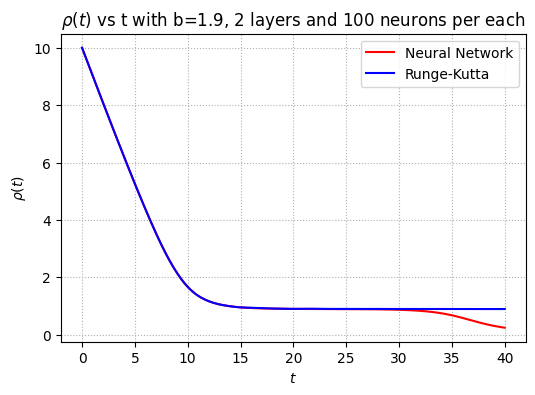

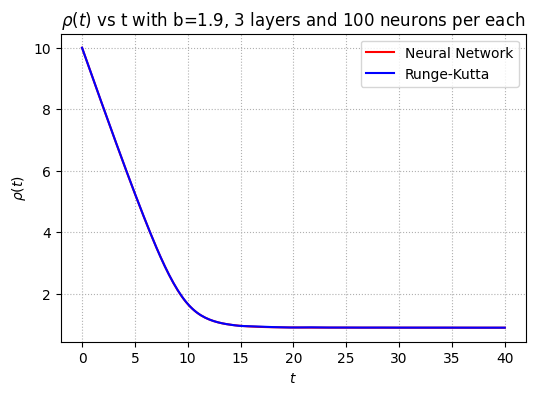

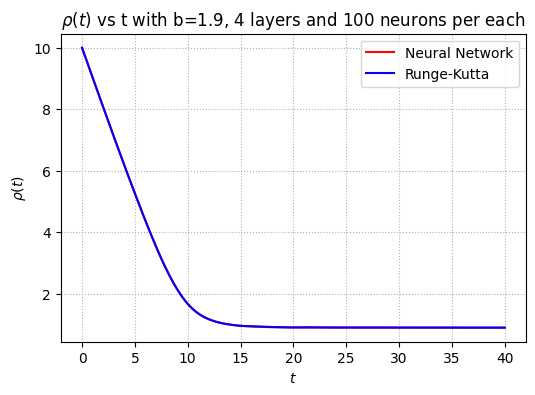

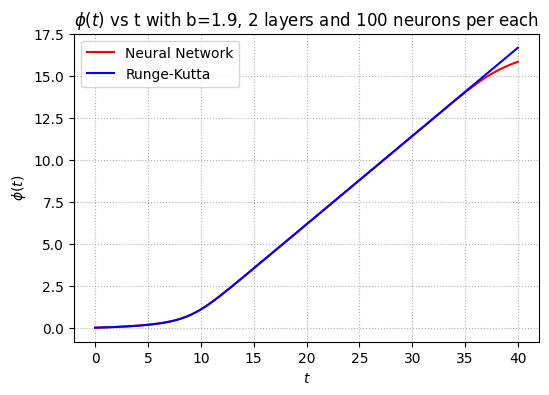

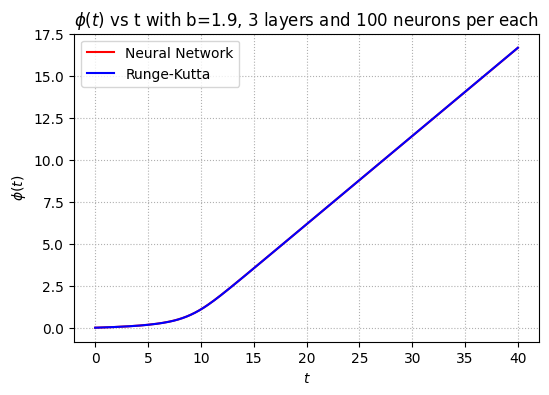

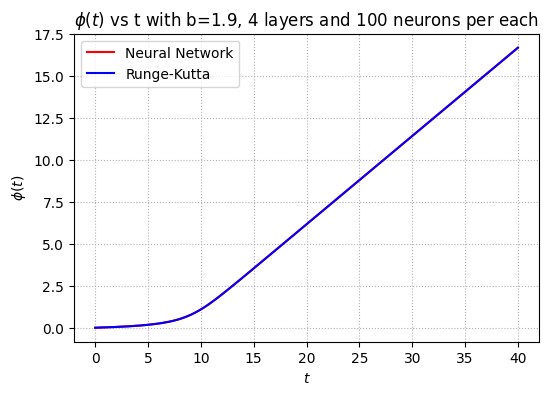

In [ ]:
# Let's plot and compare the results

plt.figure(figsize=(6,4))
plt.title('y vs x with b=1.9, 2 layers and 100 neurons per each')
plt.plot(x_nn_tot100n[0],y_nn_tot100n[0], ls='-', color='red', label='Neural Network',zorder=1)
plt.plot(x_num,y_num, ls='-', color='blue', label='Runge-Kutta',zorder=2)
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.figure(figsize=(6,4))
plt.title('y vs x with b=1.9, 3 layers and 100 neurons per each')
plt.plot(x_nn_tot100n[1],y_nn_tot100n[1], ls='-', color='red', label='Neural Network')
plt.plot(x_num,y_num, ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.figure(figsize=(6,4))
plt.title('y vs x with b=1.9, 4 layers and 100 neurons per each')
plt.plot(x_nn_tot100n[2],y_nn_tot100n[2], ls='-', color='red', label='Neural Network')
plt.plot(x_num,y_num, ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.figure(figsize=(6,4))
plt.title(r'$\rho(t)$ vs t with b=1.9, 2 layers and 100 neurons per each')
plt.plot(X_train,rho_nn_tot100n[0], ls='-', color='red', label='Neural Network')
plt.plot(X_train,rho_num,ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel(r'$\rho(t)$')
plt.show()

plt.figure(figsize=(6,4))
plt.title(r'$\rho(t)$ vs t with b=1.9, 3 layers and 100 neurons per each')
plt.plot(X_train,rho_nn_tot100n[1], ls='-', color='red', label='Neural Network')
plt.plot(X_train,rho_num,ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel(r'$\rho(t)$')
plt.show()

plt.figure(figsize=(6,4))
plt.title(r'$\rho(t)$ vs t with b=1.9, 4 layers and 100 neurons per each')
plt.plot(X_train,rho_nn_tot100n[2], ls='-', color='red', label='Neural Network')
plt.plot(X_train,rho_num,ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel(r'$\rho(t)$')
plt.show()


plt.figure(figsize=(6,4))
plt.title('$\phi(t)$ vs t with b=1.9, 2 layers and 100 neurons per each')
plt.plot(X_train,phi_nn_tot100n[0], ls = '-', color = 'red', label='Neural Network')
plt.plot(X_train,phi_num, ls = '-', color = 'blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$\phi(t)$')
plt.show()

plt.figure(figsize=(6,4))
plt.title('$\phi(t)$ vs t with b=1.9, 3 layers and 100 neurons per each')
plt.plot(X_train,phi_nn_tot100n[1], ls = '-', color = 'red', label='Neural Network')
plt.plot(X_train,phi_num, ls = '-', color = 'blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$\phi(t)$')
plt.show()

plt.figure(figsize=(6,4))
plt.title('$\phi(t)$ vs t with b=1.9, 4 layers and 100 neurons per each')
plt.plot(X_train,phi_nn_tot100n[2], ls = '-', color = 'red', label='Neural Network')
plt.plot(X_train,phi_num, ls = '-', color = 'blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$\phi(t)$')
plt.show()

Let's pass to examine the application as HNN.

In [ ]:
#TRAINING

import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


import time
import numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import solve_ivp
from tensorflow import keras, Variable
from tensorflow.keras.optimizers import SGD, RMSprop, Nadam, Adagrad
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU, Concatenate
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import Conv1D, Conv2D,  UpSampling2D, Conv1DTranspose, MaxPool1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.python.framework.ops import disable_eager_execution
import sys
disable_eager_execution()

def info(obj,name):
  print(name,' shape: ',np.shape(obj),' type: ',type(obj), '\n')

np.random.seed(1)
keras.utils.set_random_seed(812)       #c'è differenza tra questi due comandi? La prima funzione fissa il seme della generazione dei numeri pseudocasuali su numpy,
                                       #il secondo serve per inizializzare in modo randomico i parametri della rete. Fissando il seme si fa in modo che ogni volta che
                                       #si ripete il codice i parametri iniziali della rete siano gli stessi

def scheduler(epoch, lr):              #si noti che in ingresso alla funzione si ha lr perchè questa funzione viene chiamata durante il training della rete dove viene usato lr:
                                       #per le prime 5000 epoche è uguale a lri, ma dopo di esse viene fatto diminuire con la legge riportata nell'else
  if epoch <= 5000:
    lr = lri
  else:
    lr = lr/(1+0.00001*epoch)
  return lr

#### Geodesic Parameters
L  = 1
af = 0.1
b  = 1.89
E = 1

#### Integration Parameters
rho_0   = 10
phi_0   = np.arcsin(b/rho_0)
#prho_0 = 0
prho_0  = 0.9920919014332083133167674430940523733154
t_start = 0
t_final = 40
npoints = 2000
t_eval  = np.linspace(t_start,t_final,npoints)
EPOCHS  = 100000

#if b==1.9:
#  def rad(rho):
#    return -(rho**2 + af**2)*tf.math.sqrt(0.000000000000000000000000000000000001+tf.math.abs((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2)))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
#else:
#  def rad(rho):
#    return -(rho**2 + af**2)*tf.math.sqrt((rho**2+L**2)**2+(af-b)*(rho**2 *(af+b) + 2*af*L**2))/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

#def ang(rho):
#  return (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)

def f(t):
  return 1 - tf.math.exp(-t)

def df(t):
  return tf.math.exp(-t)

def custom_activation(x):
  return tf.math.sin(x)

def hamiltonian(rho,prho):
    return prho**2*(rho**2+af**2)+b**2*E**2+E**2*af**2-(b*E*af-E*L**2)**2/(rho**2+af**2)-E**2*(rho**2+af**2+2*L**2)



def custom_loss(t,N):

  def loss(y_true, y_pred):         #questo è un trucco per far fare alla rete ciò che ci serve: lei legge, come argomento della funzione loss, y_true e y_pred, quando a noi
                                    #interessa che la loss dipenda da N e t. Allora, facciamo restituire dalla funzione custom_loss la funzione loss, che è quella che la rete
                                    #"riconosce", ma visto che in ingresso a custum_loss ci sono N e t, questi entrano nella loss calcolata e minimizzata poi (durante il training)
                                    #dalla rete, ottenendo il nostro obiettivo
    ft  = f(t)
    dft = df(t)

    with tf.GradientTape() as tape:
      tape.watch(t)
      predictions = model(t,training=False)                   #è equivalente a model.predict? No, prima va allenata e dopo predice con model.predict
    gradients     = tape.batch_jacobian(predictions,t)        #vorrei capire meglio. La spiegazione è che sembra che con tape.gradient si calcolino le derivate dell'output
                                                              #rispetto a t e poi vengano sommate tutte le derivate, invece con batch_jacobian le derivate non vengano
                                                              #sommate ed è ciò che vogliamo
    gradients     = tf.reshape(gradients, (-1,2))

    rho             = rho_0+ft[:,0]*N[:,0]
    #phi             = phi_0+ft[:,0]*N[:,1]
    #prho            = prho_0+ft[:,0]*N[:,1]
    prho            = N[:,1]

    rho_dot          = ft[:,0]*gradients[:,0] + dft[:,0]*N[:,0]
    #phi_dot          = ft[:,0]*gradients[:,1] + dft[:,0]*N[:,1]
    #prho_dot         = ft[:,0]*gradients[:,1] + dft[:,0]*N[:,1]
    prho_dot         = gradients[:,1]


    eq1Ham           = tf.square(rho_dot - 2*(rho**2+af**2)*prho)
    #eq2Ham           = tf.square(phi_dot - 2*b*E)
    eq3Ham           = tf.square(prho_dot + (2*rho*(af*b*E - E*L*L)**2)/((af**2+rho**2)**2) - 2*E*E*rho + 2*rho*prho*prho)
    #total_loss_Ham    = eq1Ham  +  eq2Ham + eq3Ham
    #total_loss_Ham    = eq1Ham + eq3Ham + 1.5*tf.square(hamiltonian(rho,prho))
    total_loss_Ham    = eq1Ham + eq3Ham


    return tf.reduce_mean(total_loss_Ham)                #qui viene restituita come loss la media dei valori assunti da essa ai diversi tempi (quindi questo è il valore della loss
                                                     #alla data epoca)

  return loss     #questa loss è la funzione di sopra, quella riconosciuta dalla rete

# initial condition
z0  = np.array([rho_0,prho_0])

arc     = 'arc1'
lri     = 2e-4
X_train = t_eval # np.array([ [0], [0.5] ])
Y_train = np.zeros(len(X_train))

initializer  = 'random_normal'                    #l'inizializzatore serve a generare casualmente i parametri della rete e qui viene fatto con una distribuzione normale
opt          =  Adam(learning_rate=lri)

csv_logger   = CSVLogger(f'loss.dat', append=False, separator=' ')   #Questa callback serve a scrivere su un file il valore della loss a ogni epoca volta per volta
my_callbacks = [csv_logger]

if arc == 'arc1':                                 #ricordo che qui viene impostata l'architettura della rete
  input_layer = Input(shape=(1))
  branch = Dense(50, kernel_initializer=initializer)(input_layer)
  branch = custom_activation(branch)
  branch = Dense(50, kernel_initializer=initializer)(branch)
  branch = custom_activation(branch)
  output_layer = Dense(2, kernel_initializer=initializer)(branch)



model  = Model( inputs = input_layer , outputs = output_layer)    #qui invece viene impostato il modello
model.compile( loss=custom_loss(input_layer,output_layer), optimizer = opt )   #e qui viene compilato

# model.summary()
# param = model.count_params()


start_time = time.time()
print(f'Training with {EPOCHS} epochs ...')
history = model.fit( x = X_train, y = None, epochs=EPOCHS, verbose = 0,batch_size = len(X_train), callbacks = [my_callbacks]) #qui invece viene fatto il training, ossia la minimizzazione della loss alle
                                                                                                                              #varie epoche. Avremmo potuto mettere y=Y_train, essendo comunque tutti 0.

print(f'Elapsed time = {time.time()-start_time} sec = {(time.time()-start_time)/60} min')

# Plot Loss Function
loss_1 = history.history['loss']     #grazie alla callback csv_logger, potremmo vedere come va la loss alle varie epoche senza aspettare tutto il training, cosa invece necessaria
                                     #con history.history
plt.figure(figsize=(6,4))
plt.plot(loss_1,color='red')
plt.yscale('log')
plt.xscale('log')
plt.grid(0.5,ls='dotted')
plt.xlabel('Epochs')
plt.ylabel('Loss')


# Prediction
prediction = model.predict(X_train)
solution = []
for n in range(len(prediction)):
  z = z0 + (1-np.exp(-X_train[n]))* prediction[n]
  solution.append(z)
prediction = np.transpose(solution)
rho_nn = prediction[0]
prho_nn= prediction[1]
#phi_nn = prediction[1]
#x_nn = rho_nn*np.cos(phi_nn)
#y_nn = rho_nn*np.sin(phi_nn)


Training with 100000 epochs ...


KeyboardInterrupt: 

In [ ]:
print(hamiltonian(rho_0,prho_0))
print(len(rho_nn))
for i,rho in enumerate(rho_nn):
  print(hamiltonian(rho,prediction[1][i]))

In [ ]:
len(prediction[1][5:])

195

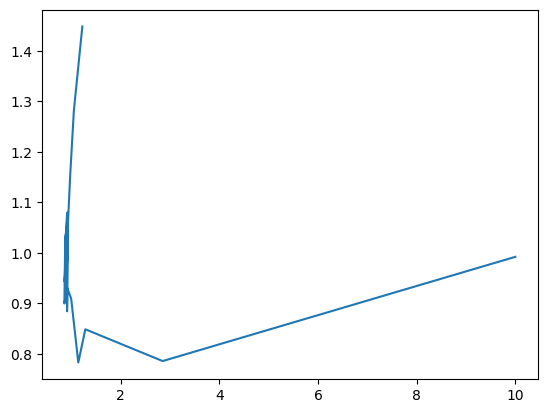

In [ ]:
plt.plot(prediction[0],prediction[1])

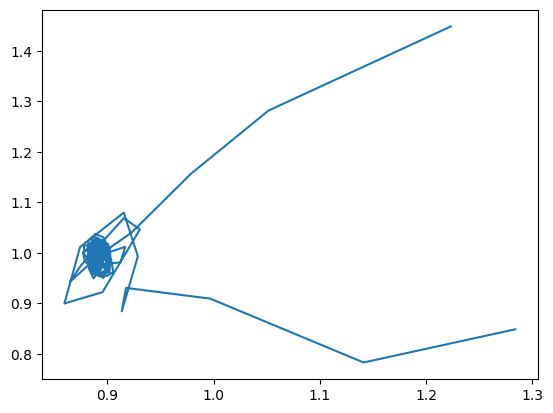

In [ ]:
plt.plot(prediction[0][2:],prediction[1][2:])

In [ ]:
# Numerical Integration via solve_ivp using Runge-Kutta method of order 5(4)
def system(t,y):
  rho, prho = y
  drho_ds = (2*(rho**2+af**2)*prho)
  dprho_ds = -2*rho*(af*b*E-E*L**2)/(af**2+rho**2)**2 + 2*E**2*rho - 2*prho**2*rho
  #dphi_dt = (b*rho*rho + af*L*L)/((rho**2 + 2*L*L)*af**2 + (rho**2 + L**2)**2 - af*b*L*L)
  return [drho_ds, dprho_ds]

num_sol = solve_ivp(system, t_span=(t_eval[0],t_eval[-1]), y0=[rho_0,prho_0], t_eval = t_eval)
rho_num = num_sol.y[0]
prho_num = num_sol.y[1]
#phi_num = num_sol.y[1]
#x_num = rho_num*np.cos(phi_num)
#y_num = rho_num*np.sin(phi_num)
print(rho_num)

[10.]


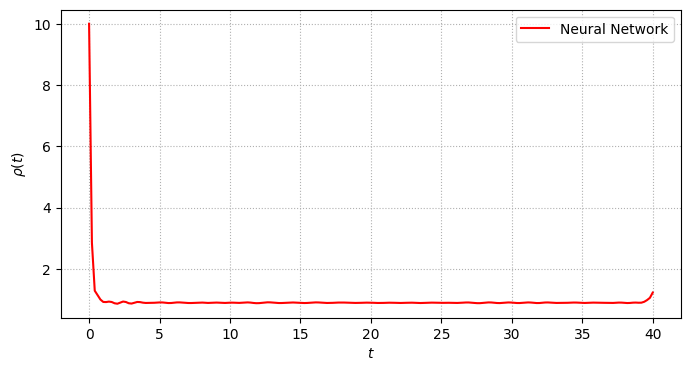

"\nplt.figure(figsize=(8,4))\nplt.plot(X_train,phi_nn, ls = '-', color = 'red', label='Neural Network')\nplt.plot(X_train,phi_num, ls = '-', color = 'blue', label='Runge-Kutta')\nplt.grid(0.5,ls='dotted')\nplt.legend(loc='best')\nplt.xlabel('$t$')\nplt.ylabel('$\\phi(t)$')\nplt.show()\n"

In [ ]:
# Let's plot and compare the results
'''
plt.figure(figsize=(8,4))
plt.plot(x_nn,y_nn, ls='-', color='red', label='Neural Network')
plt.plot(x_num,y_num, ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()
'''
plt.figure(figsize=(8,4))
plt.plot(X_train,rho_nn, ls='-', color='red', label='Neural Network')
#plt.plot(X_train,rho_num,ls='-', color='blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel(r'$\rho(t)$')
plt.show()

'''
plt.figure(figsize=(8,4))
plt.plot(X_train,phi_nn, ls = '-', color = 'red', label='Neural Network')
plt.plot(X_train,phi_num, ls = '-', color = 'blue', label='Runge-Kutta')
plt.grid(0.5,ls='dotted')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$\phi(t)$')
plt.show()
'''